# Making Graphs for the Path of a Single Simulant

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 100)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

### Create interactive sim data 
#### Note: I have saved an old version of this data, you can choose to skip this step and just load the dataset below

Limit this to people of more interest (older) and do a small population for a long time since we aren't looking for population level information 

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 100,
                               'age_start': 50,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              },
                          'input_data':
                              {'input_draw_number': 829
                              }
                          }
                        )
sim.setup()

2023-08-07 12:22:03.873 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-08-07 12:22:03.879 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 829'].
2023-08-07 12:22:03.881 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [7]:
pop0 = sim.get_population()
#pop0

In [5]:
#sim.list_values()

data1 = pd.concat([pop0,
                   sim.get_value('outreach.exposure')(pop0.index),
                   sim.get_value('lifestyle.exposure')(pop0.index),
                   sim.get_value('polypill.exposure')(pop0.index),
                  ], axis=1)
data1.head()

In [8]:
sim_data = pd.DataFrame()
for step in list(range(0,240)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                      ], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [10]:
sim_data.lifestyle.unique()

array(['NaT'], dtype='datetime64[ns]')

In [9]:
sim_data.to_csv('/ihme/homes/lutzes/sim_graphs_240_steps_baseline_08072023.csv')

## Analyze Data and Set Up Columns for Graphing 

In [3]:
full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_100_steps_lifestyle_08042023.csv')
#full_data.head()

/tmp/ipykernel_3647039/2293335618.py:1: DtypeWarning: Columns (30,43,49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_100_steps_lifestyle_08042023.csv')


In [4]:
test_data = full_data.loc[(full_data.age > 25)]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data = test_data.rename(columns={'Unnamed: 0':'sim_id'})

In [5]:
event_data = test_data[['sim_id','exit_time','sex','alive','age_start','cause_of_death','years_of_life_lost','years_lived_with_disability','ischemic_stroke','ischemic_heart_disease_and_heart_failure','outreach','lifestyle','polypill','sbp_medication','sbp_medication_adherence','ldlc_medication','ldlc_medication_adherence','scheduled_date','visit_type','step','high_sbp','high_ldl','high_bmi','high_fpg']]
event_data.head()

sim_id exit_time     sex  alive  age_start cause_of_death  \
0       0       NaN  Female  alive       65.0       not_dead   
1       1       NaN    Male  alive       60.0       not_dead   
2       2       NaN  Female  alive       65.0       not_dead   
3       3       NaN    Male  alive       55.0       not_dead   
4       4       NaN  Female  alive       50.0       not_dead   

   years_of_life_lost  years_lived_with_disability  \
0                 0.0                          0.0   
1                 0.0                          0.0   
2                 0.0                          0.0   
3                 0.0                          0.0   
4                 0.0                          0.0   

                  ischemic_stroke  \
0  susceptible_to_ischemic_stroke   
1  susceptible_to_ischemic_stroke   
2  susceptible_to_ischemic_stroke   
3  susceptible_to_ischemic_stroke   
4  susceptible_to_ischemic_stroke   

            ischemic_heart_disease_and_heart_failure  ...  \
0  susceptible_to_ischemic_heart_disease_and_hear...  ...   
1  susceptible_to_ischemic_heart_disease_and_hear...  ...   
2  susceptible_to_ischemic_heart_disease_and_hear...  ...   
3  susceptible_to_ischemic_heart_disease_and_hear...  ...   
4  susceptible_to_ischemic_heart_disease_and_hear...  ...   

  sbp_medication_adherence   ldlc_medication ldlc_medication_adherence  \
0                     cat3      no_treatment                      cat3   
1                     cat3      no_treatment                      cat3   
2                     cat3  medium_intensity                      cat3   
3                     cat1      no_treatment                      cat3   
4                     cat3      no_treatment                      cat2   

                  scheduled_date  visit_type step    high_sbp  high_ldl  \
0  2021-06-15 21:37:52.737139200  background    0  116.390763  3.949179   
1                            NaN        none    0  111.867056  2.786267   
2                            NaN        none    0  150.931121  2.486654   
3                            NaN        none    0  128.447191  3.195077   
4                            NaN        none    0  123.215266  3.363461   

    high_bmi  high_fpg  
0  35.570161  4.359510  
1  22.318286  5.710375  
2  34.758227  5.230878  
3  31.677581  5.449284  
4  33.537161  4.269376  

[5 rows x 24 columns]

In [6]:
event_data = event_data.sort_values(['sim_id','step'])
event_data['ldl_change'] = np.where(event_data['ldlc_medication'] != event_data['ldlc_medication'].shift(1), event_data['step'],0)
event_data['sbp_change'] = np.where(event_data['sbp_medication'] != event_data['sbp_medication'].shift(1), event_data['step'],0)
#event_data.loc[event_data.sim_id == 19]

In [12]:
#event_data.loc[event_data.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']

## Creating the Graphs

In [7]:
single_sim = event_data.loc[(event_data['sim_id']==19)]
#single_sim.lifestyle #.head()

In [21]:
def visits(single_sim):
    background = single_sim.step.loc[(single_sim.visit_type=='background') & (single_sim.alive=='alive')]
    background_y = [12] * len(background)
    scheduled = single_sim.step.loc[(single_sim.visit_type=='scheduled') & (single_sim.alive=='alive')]
    scheduled_y = [12] * len(scheduled)
    emergency = single_sim.step.loc[(single_sim.visit_type=='emergency') & (single_sim.alive=='alive')]
    emergency_y = [12] * len(emergency)
    return background, background_y, scheduled, scheduled_y, emergency, emergency_y

In [9]:
def meds(single_sim):
    ldl_med = single_sim.ldl_change.loc[single_sim.ldl_change!=0]
    ldl_y = [13] * len(ldl_med)
    sbp_med = single_sim.sbp_change.loc[single_sim.sbp_change!=0]
    sbp_y = [13] * len(sbp_med)
    return ldl_med, ldl_y, sbp_med, sbp_y

In [10]:
def lifestyle_func(single_sim):
    lifestyle = single_sim.step.loc[single_sim.lifestyle.notna()]
    if len(lifestyle > 0): 
        lifestyle = lifestyle.iloc[0]
        lifestyle_y = [12]
    else:
        lifestyle_y = []
    return lifestyle, lifestyle_y

In [11]:
def sbp_func(single_sim):
    sbp_base = single_sim.iloc[0].high_sbp 
    sbp_base = round(sbp_base)
    sbp = ((single_sim['high_sbp'] - sbp_base) / 15) + 10
    return sbp, sbp_base

In [12]:
def ldl_func(single_sim):
    ldl_base = single_sim.iloc[0].high_ldl 
    ldl_base = round(ldl_base,1)
    ldl = ((single_sim['high_ldl'] - ldl_base) / 3) + 8
    return ldl, ldl_base

In [13]:
def bmi_func(single_sim):
    bmi_base = single_sim.iloc[0].high_bmi 
    bmi_base = round(bmi_base,1)
    bmi = ((single_sim['high_bmi'] - bmi_base) / 5) + 6
    return bmi, bmi_base

In [14]:
def fpg_func(single_sim):
    fpg_base = single_sim.iloc[0].high_fpg 
    fpg_base = round(fpg_base,1)
    fpg = ((single_sim['high_fpg'] - fpg_base) / 3) + 4
    return fpg, fpg_base

In [15]:
def health_events(single_sim): 
    died = single_sim.step.loc[single_sim.alive=='dead']
    if len(died > 0): 
        died = died.iloc[0]
        died_y = [2]
    else: 
        died_y = []
    MI = single_sim.step.loc[single_sim.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']
    MI = MI[1:].values.tolist()
    MI[:] = [x for x in MI if x <= died]
    MI_y = [2] * len(MI)
    HF = single_sim.step.loc[(single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_residual') | (single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_from_ischemic_heart_disease')]
    if len(HF > 0): 
        HF = HF.iloc[0]
        HF_y = [2]
    else: 
        HF_y = []
    stroke = single_sim.step.loc[single_sim.ischemic_stroke=='acute_ischemic_stroke']
    stroke_y = [2] * len(stroke)
    if (MI or len(stroke > 0)):
        died = died + 1
    return died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y

/tmp/ipykernel_3647039/1176839070.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


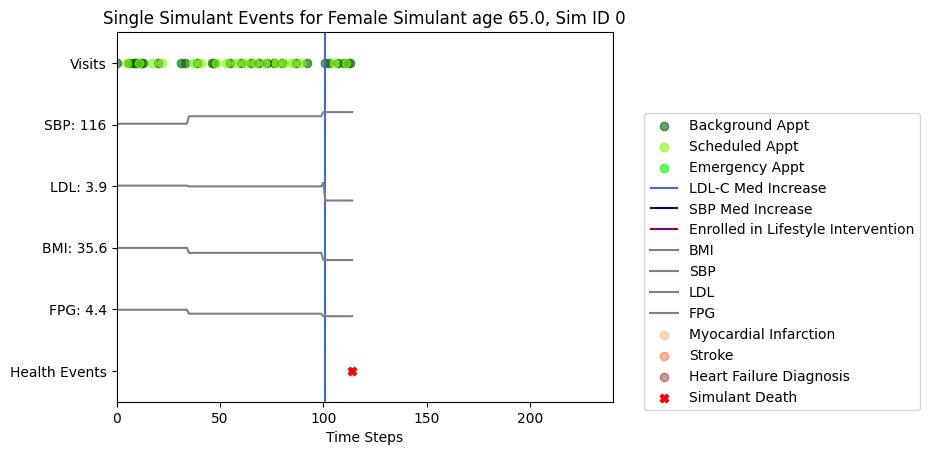

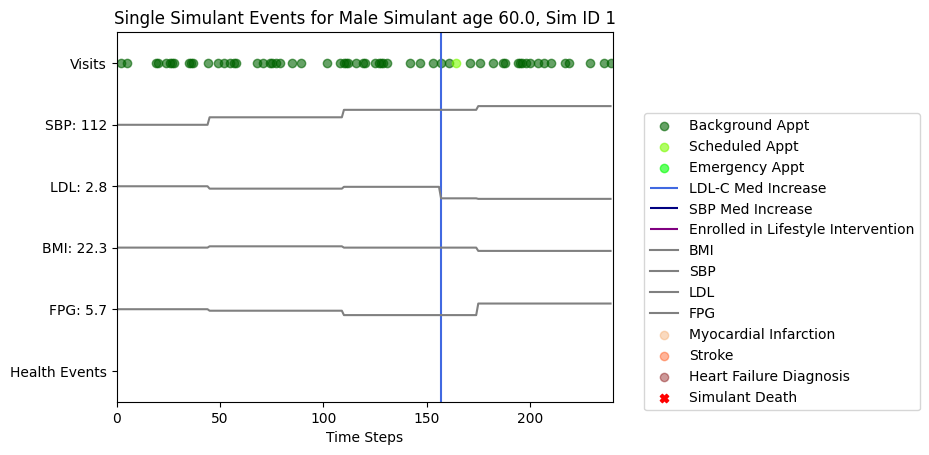

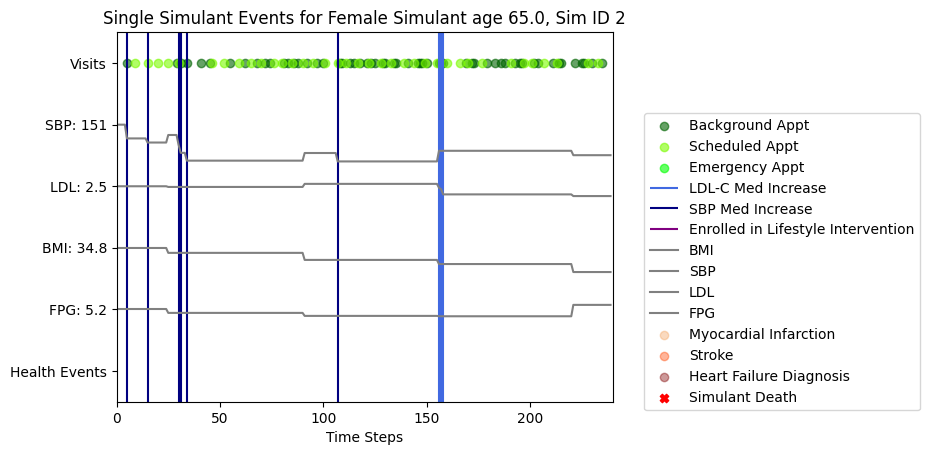

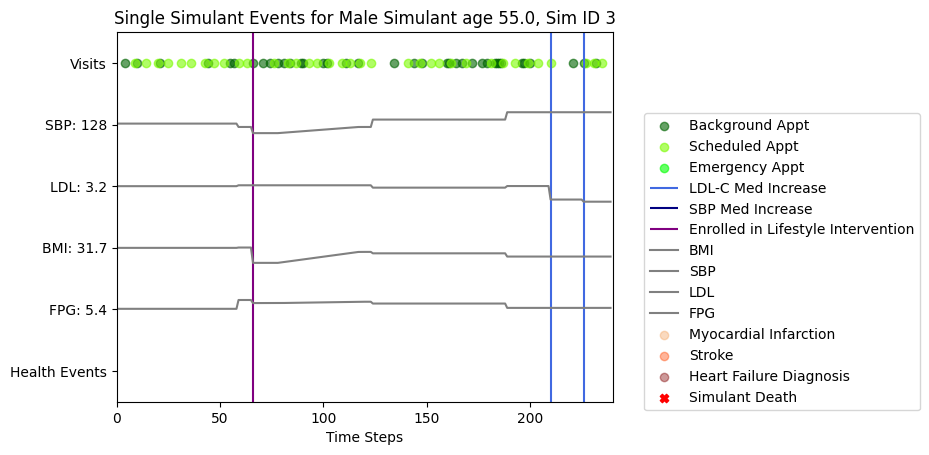

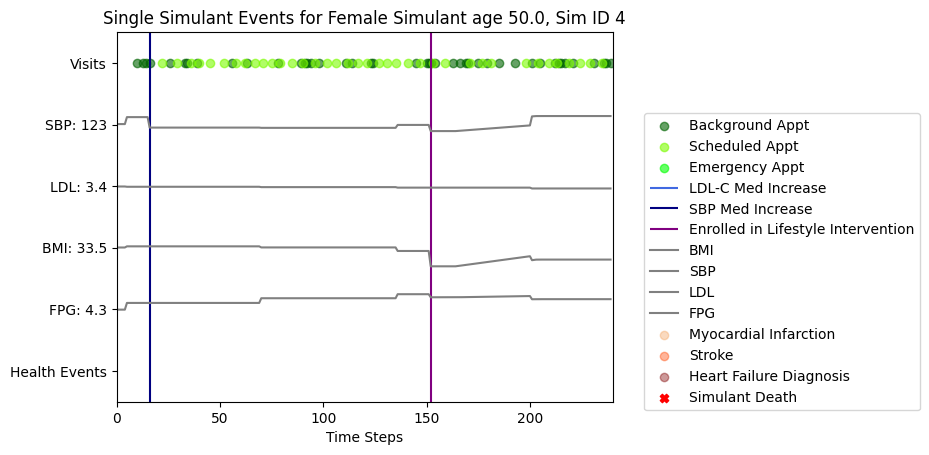

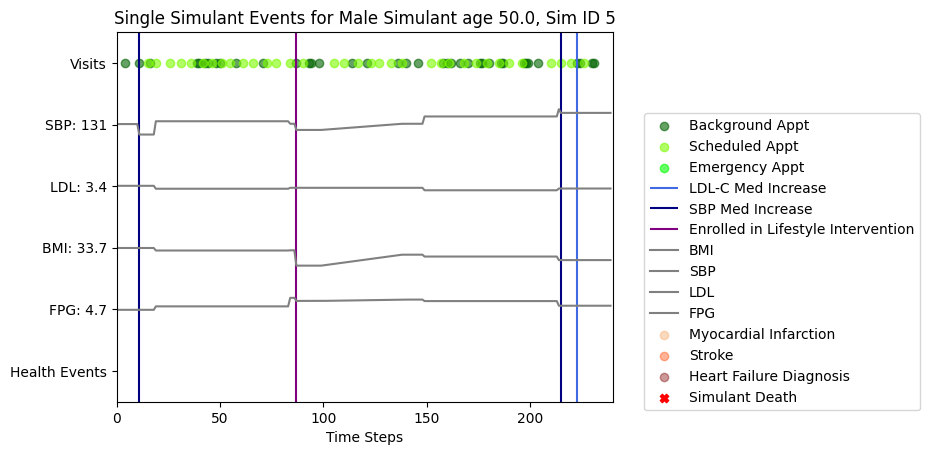

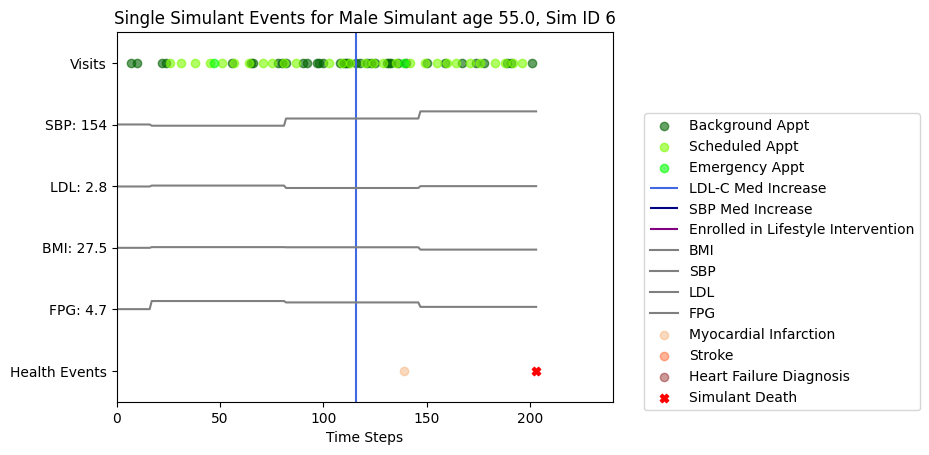

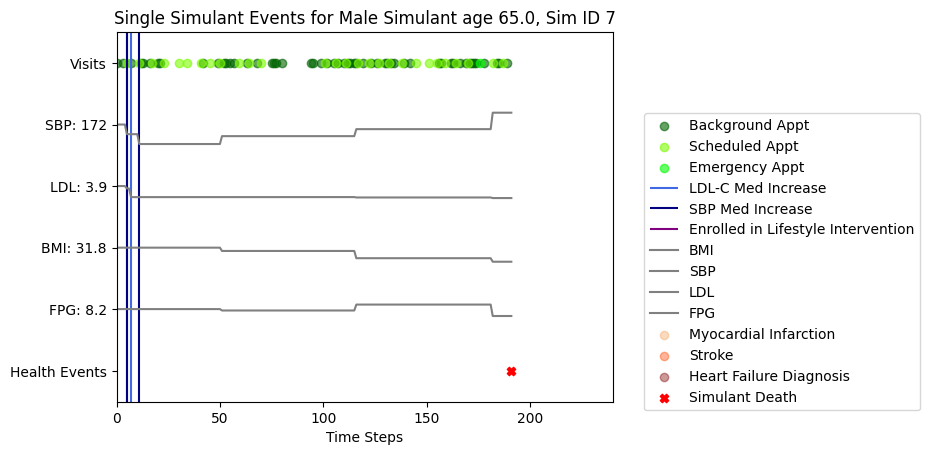

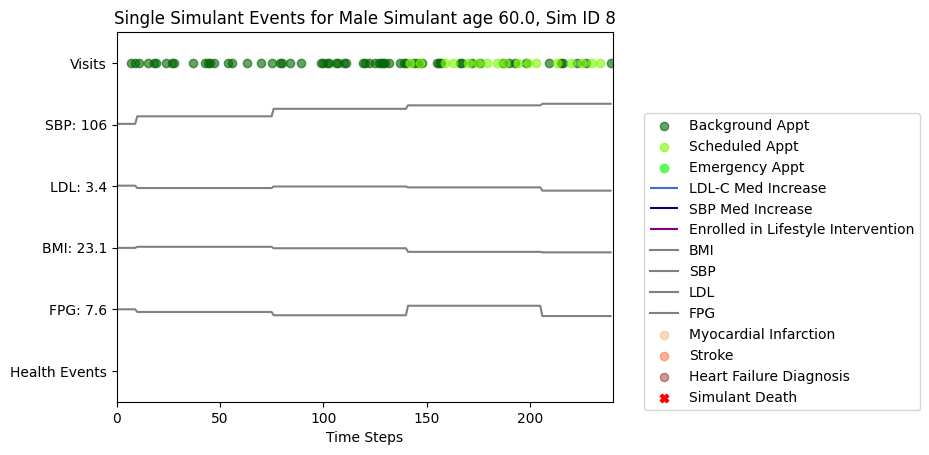

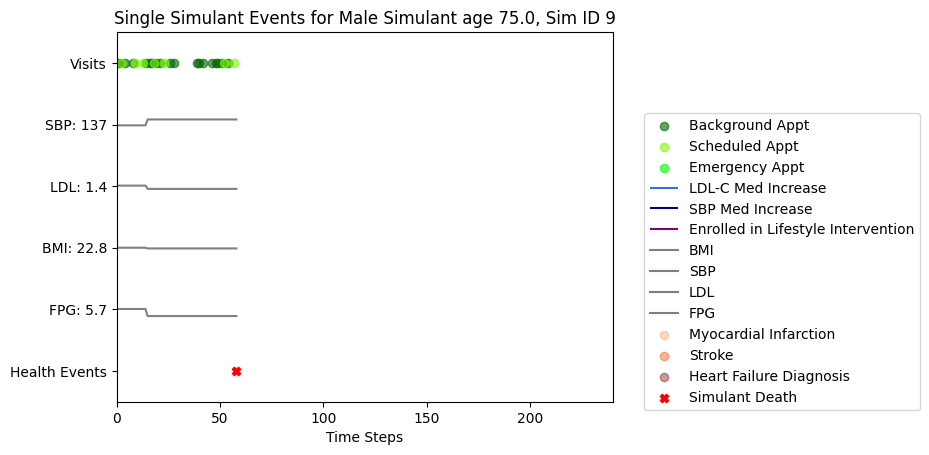

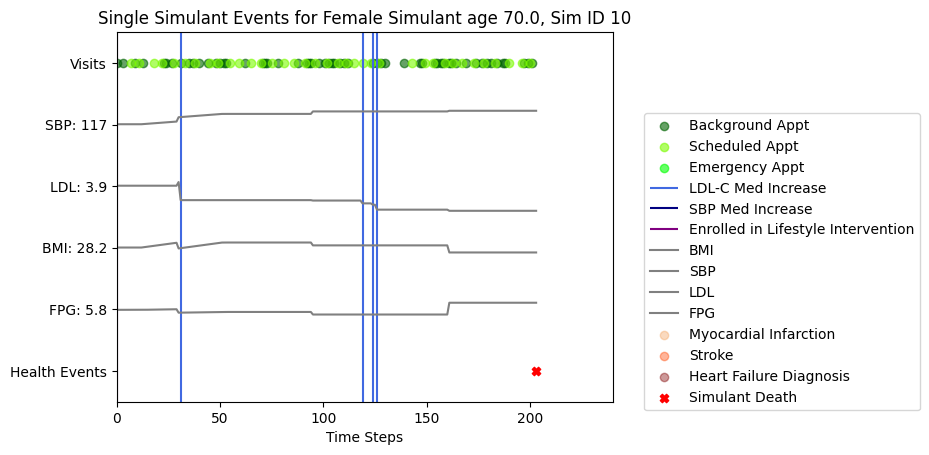

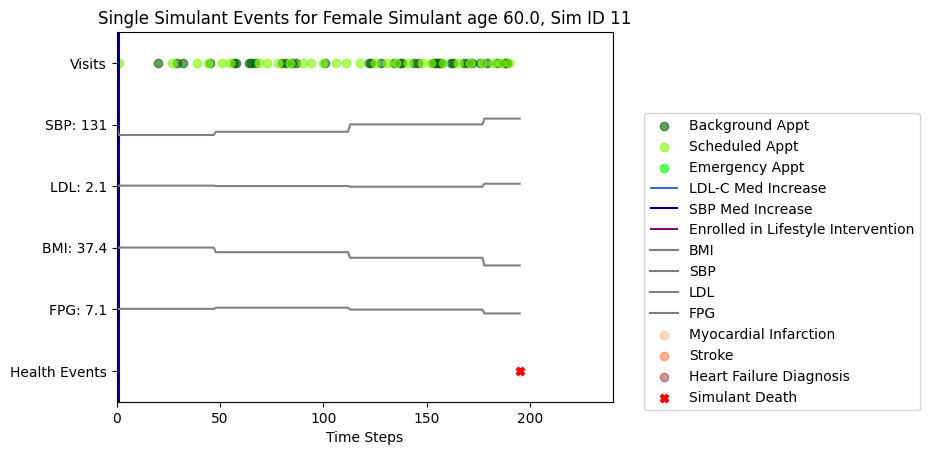

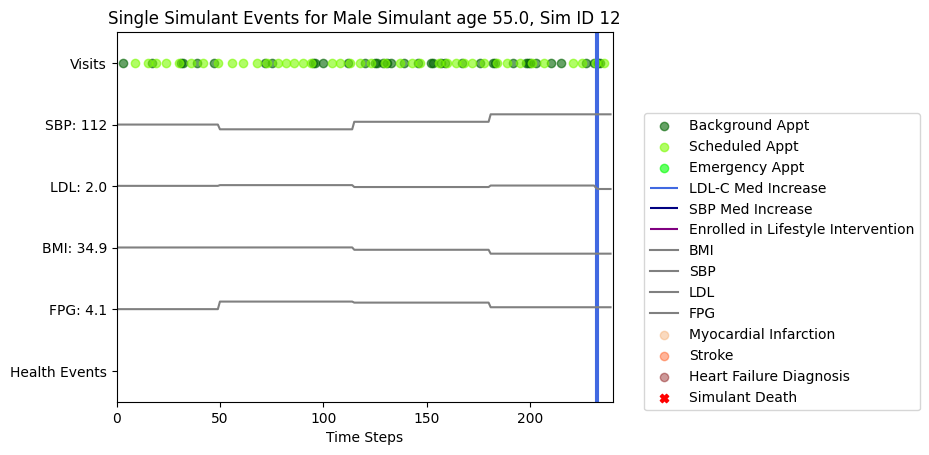

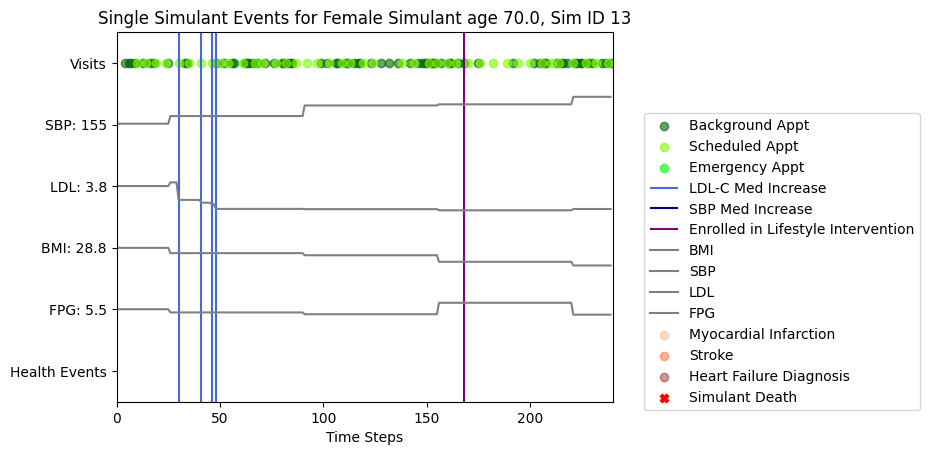

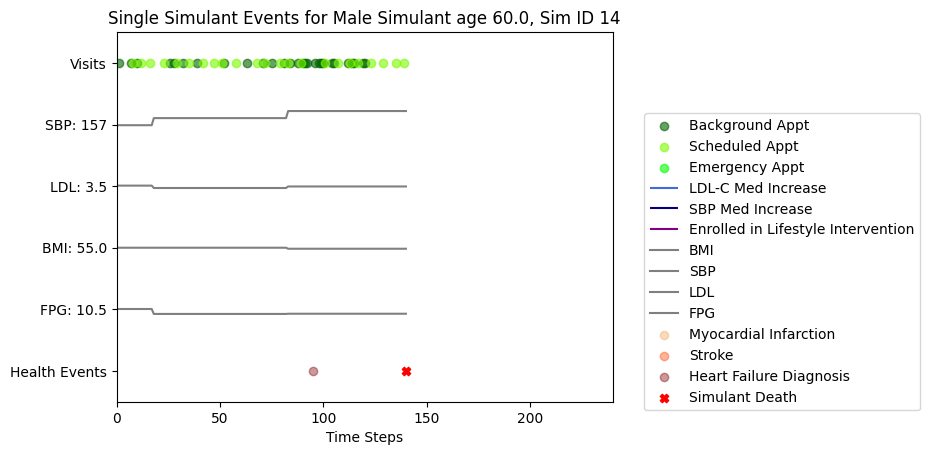

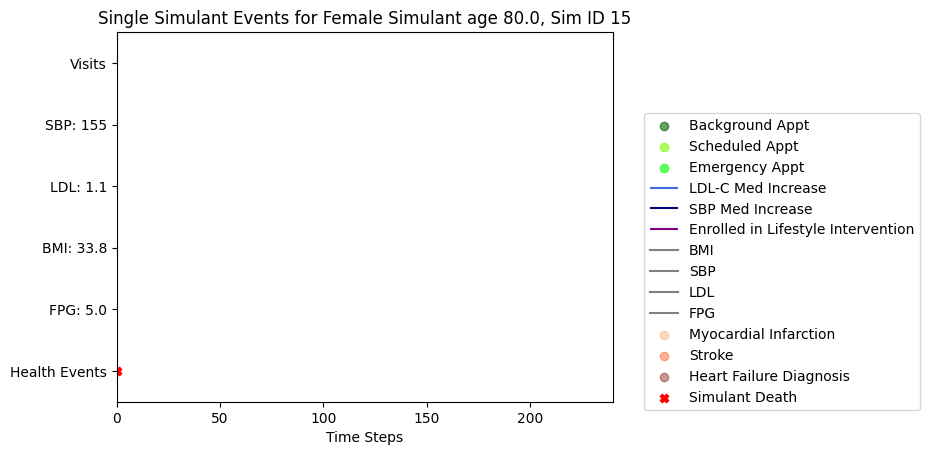

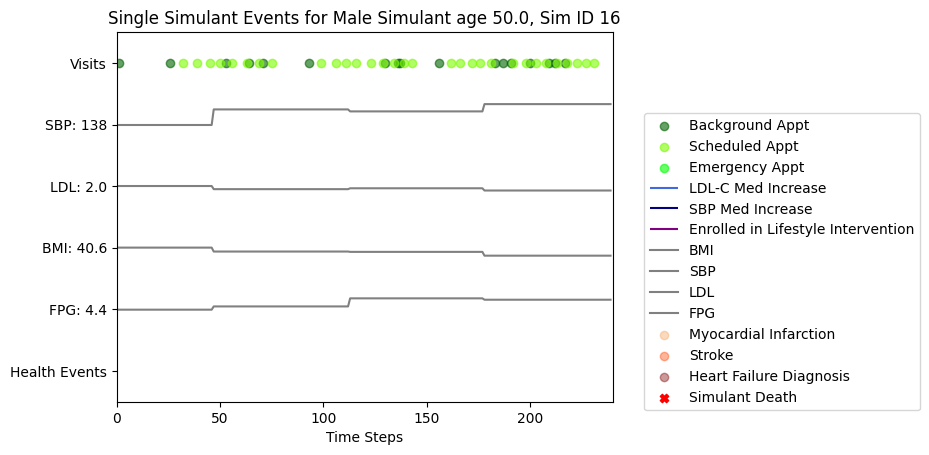

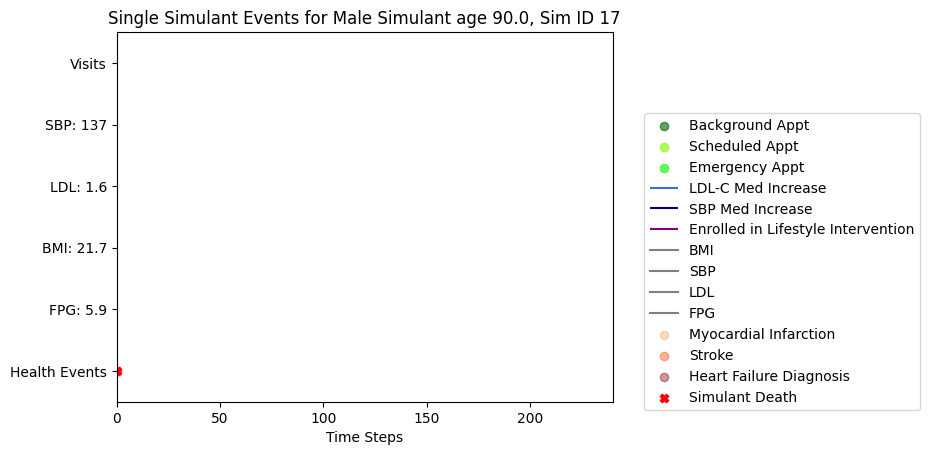

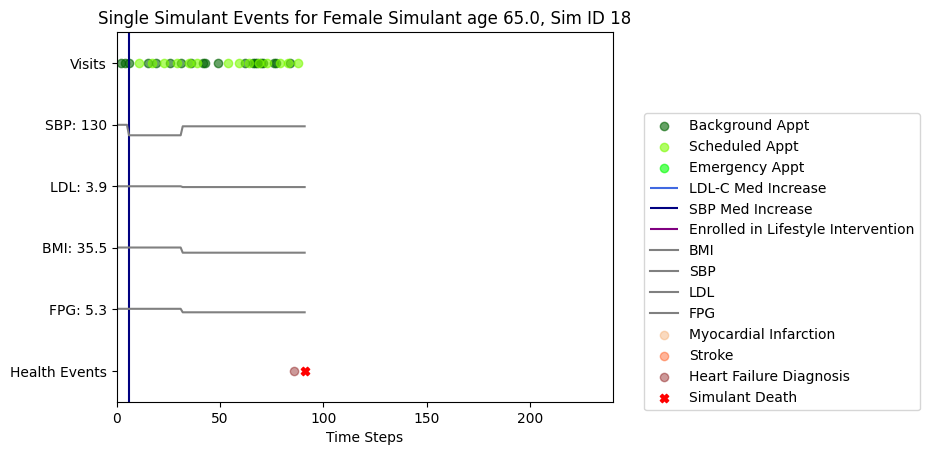

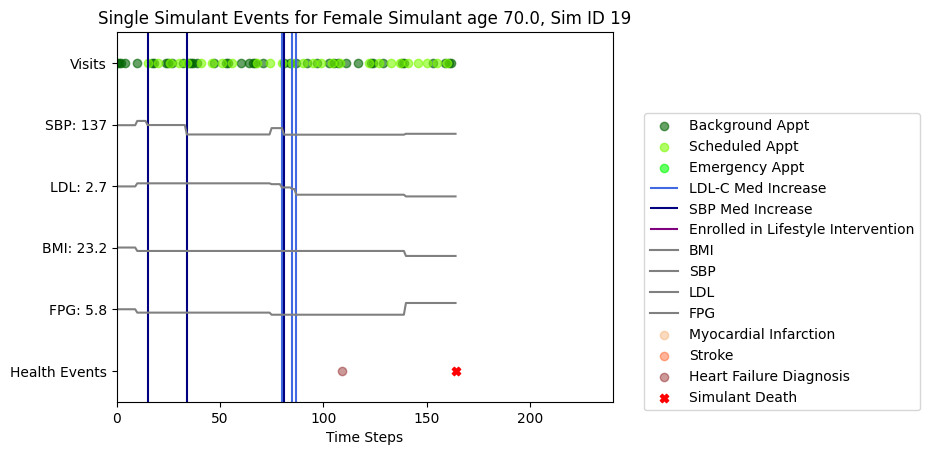

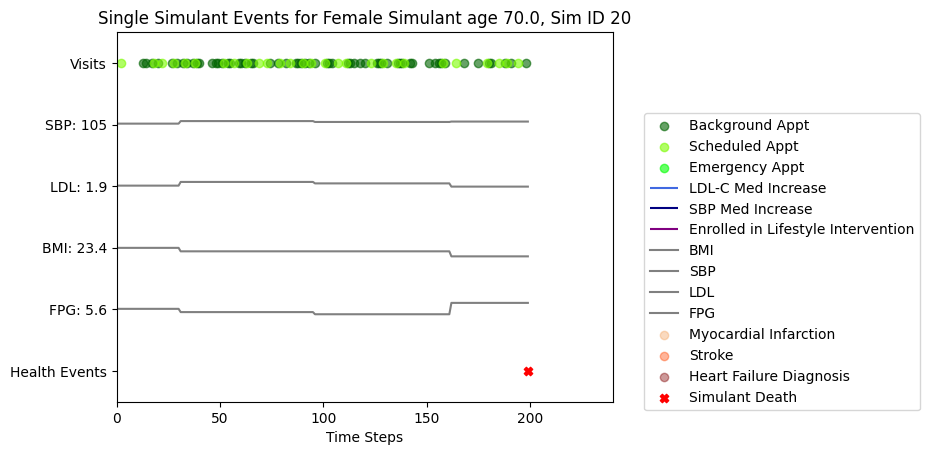

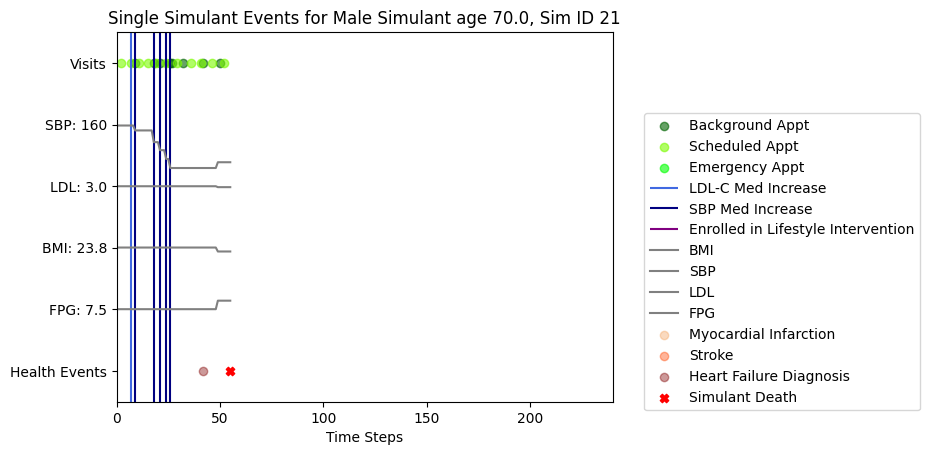

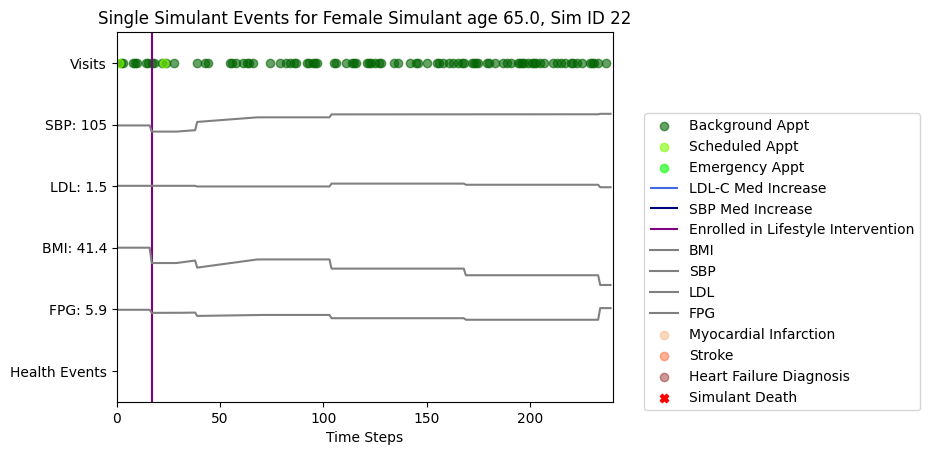

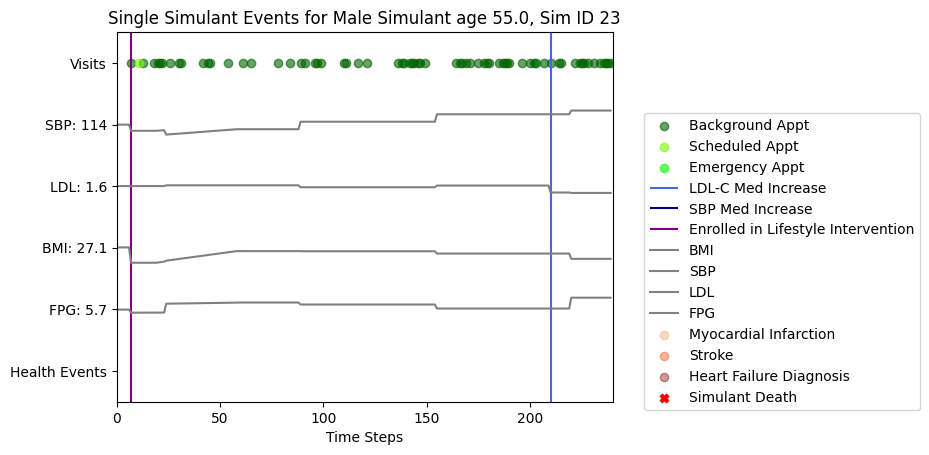

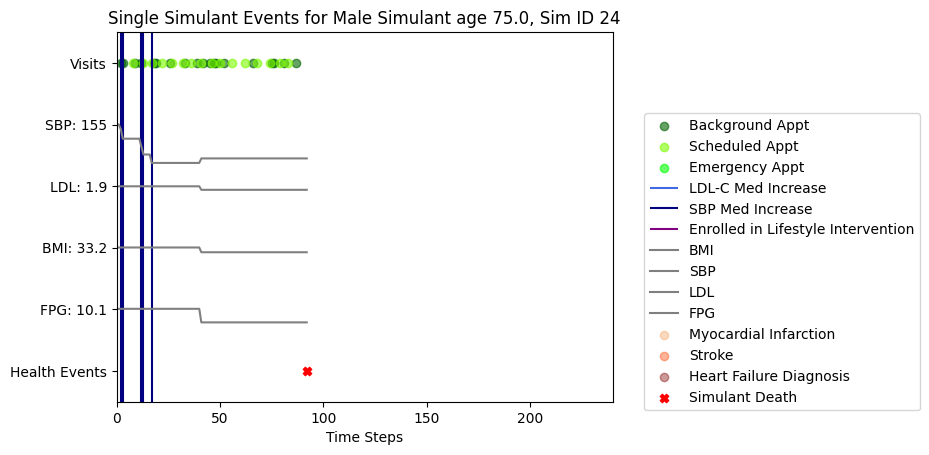

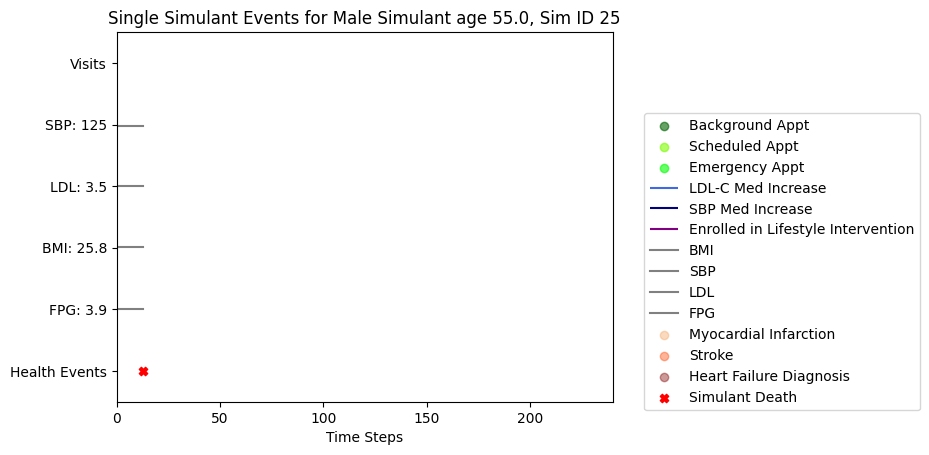

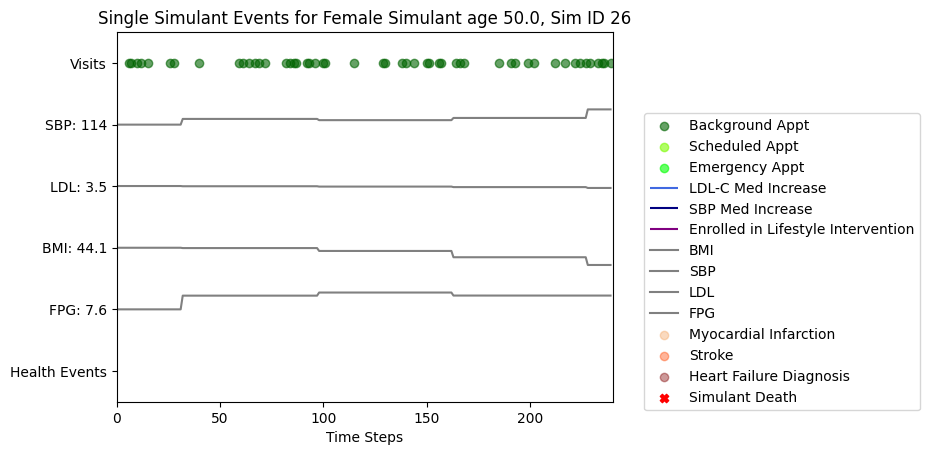

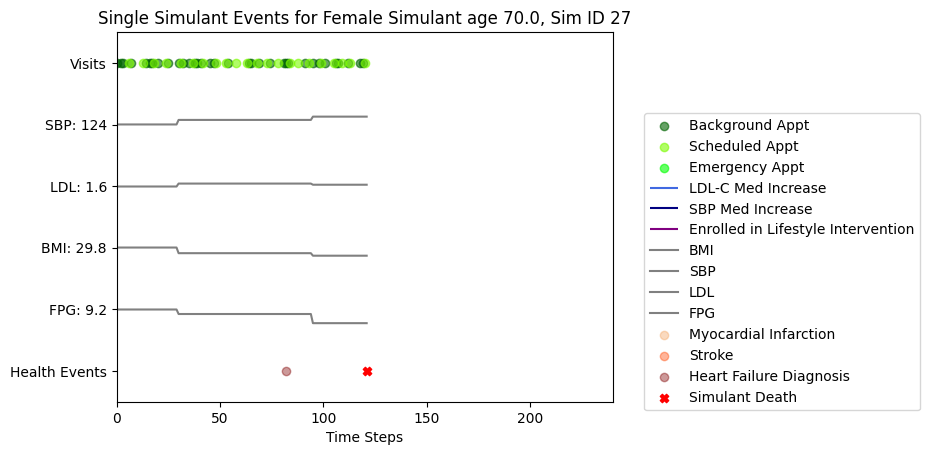

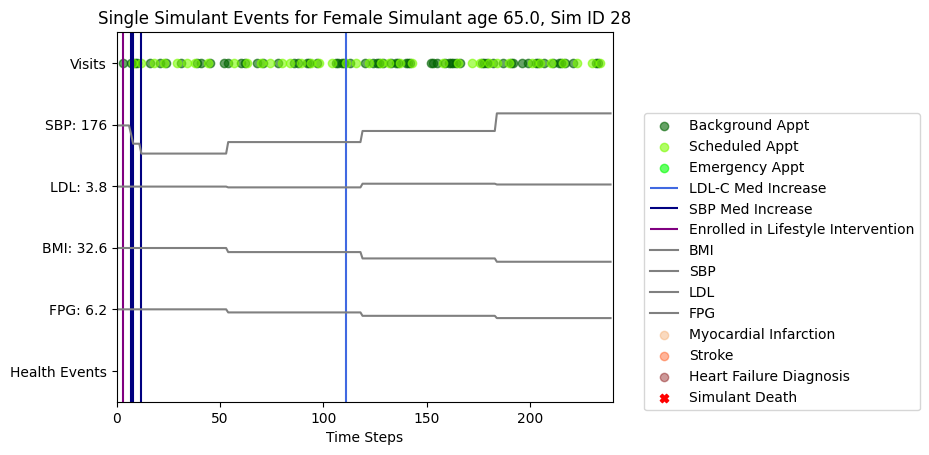

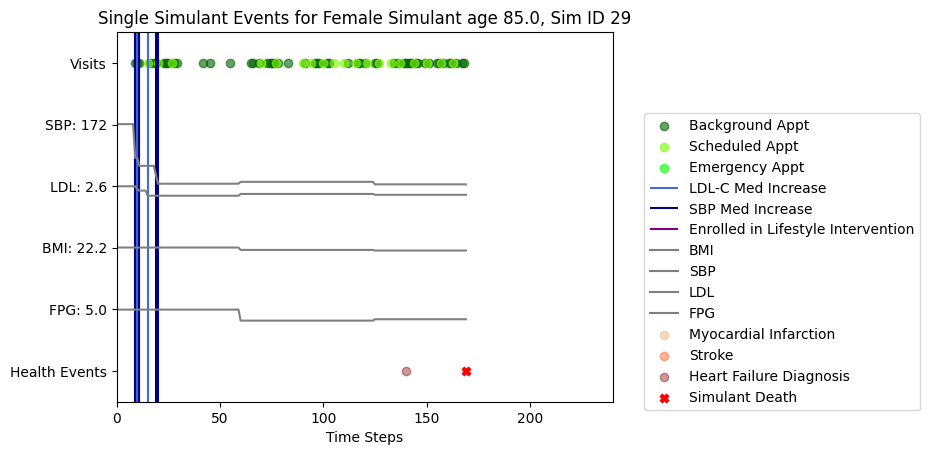

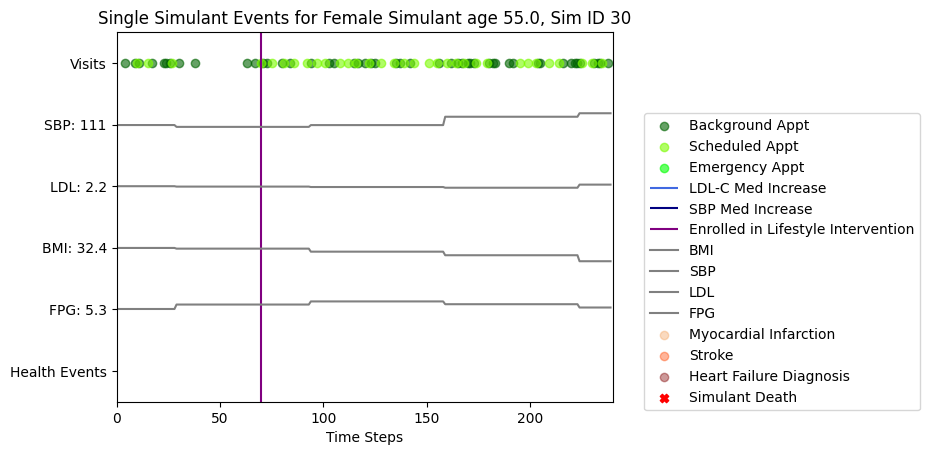

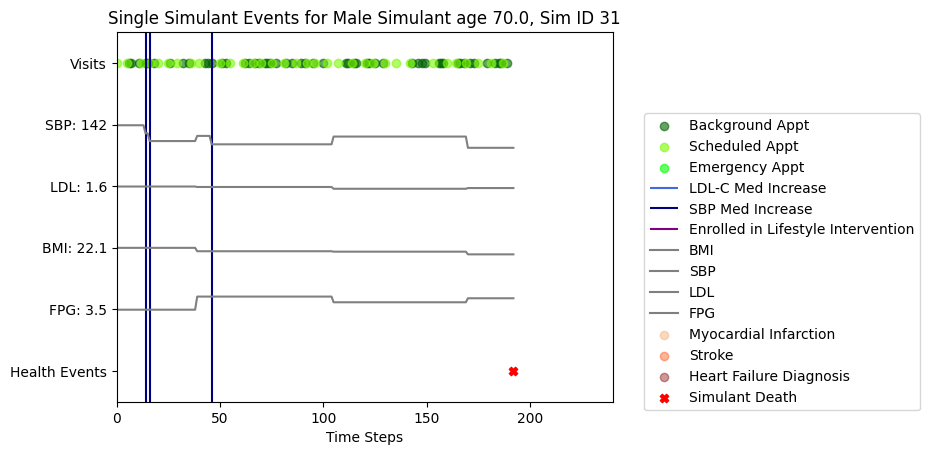

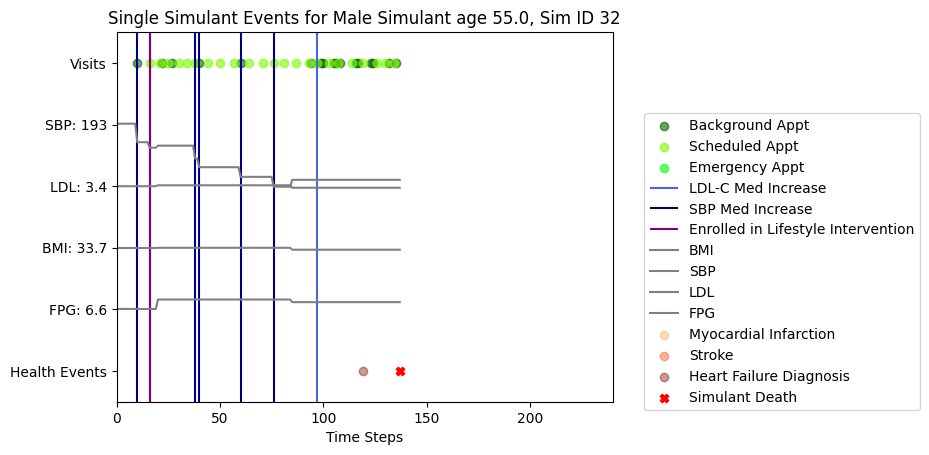

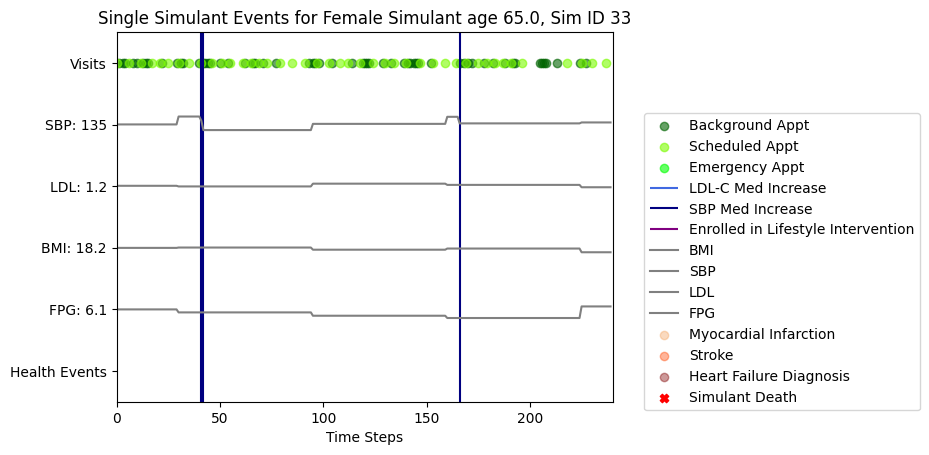

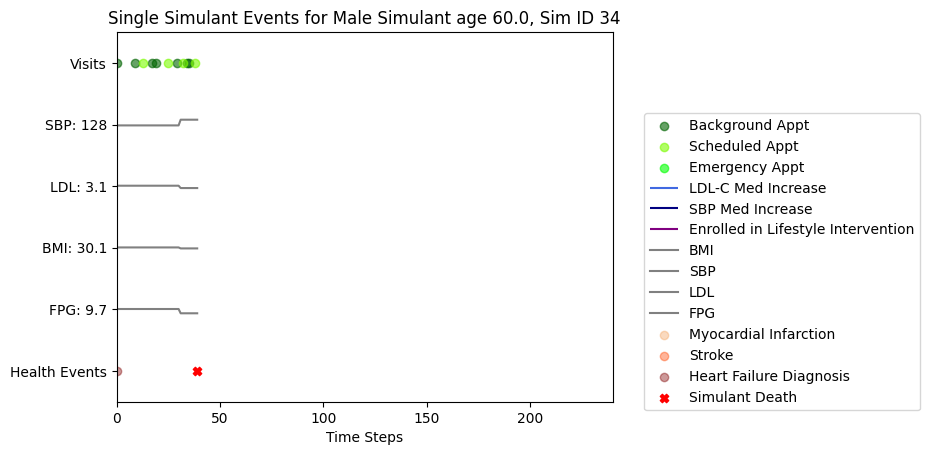

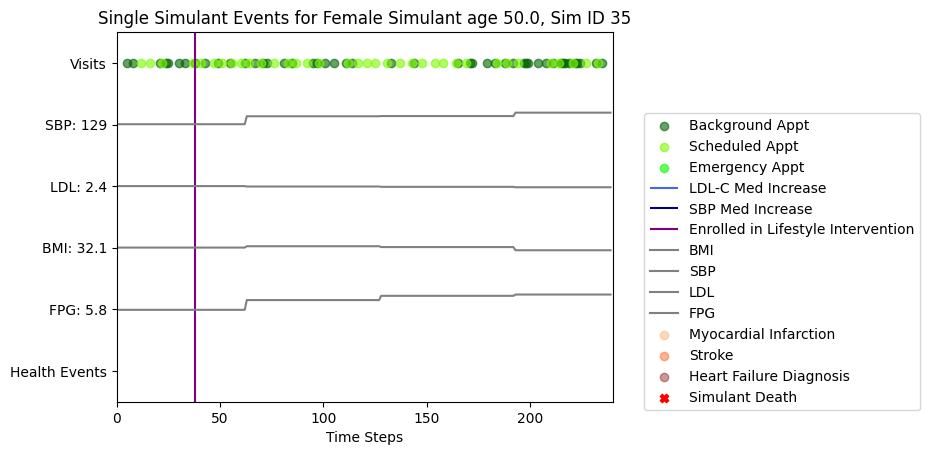

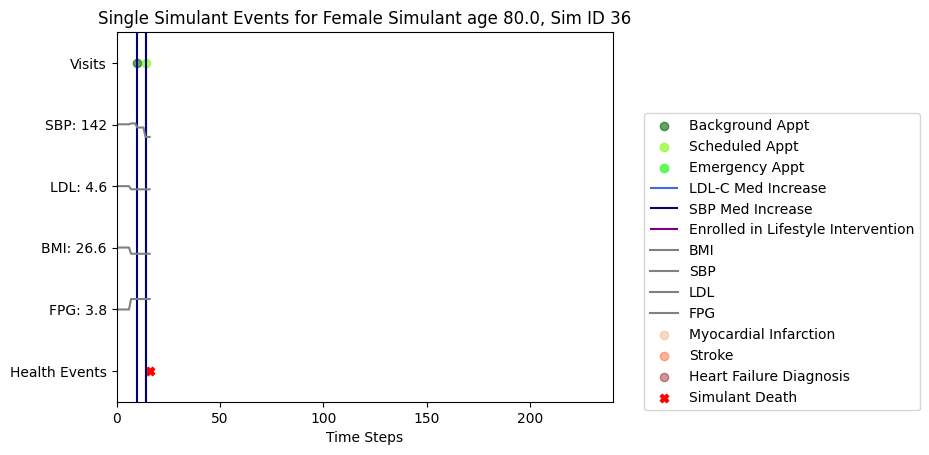

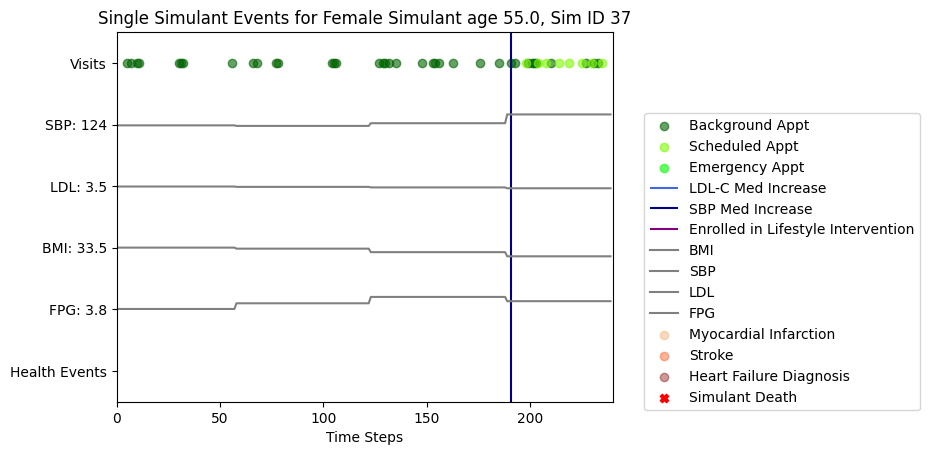

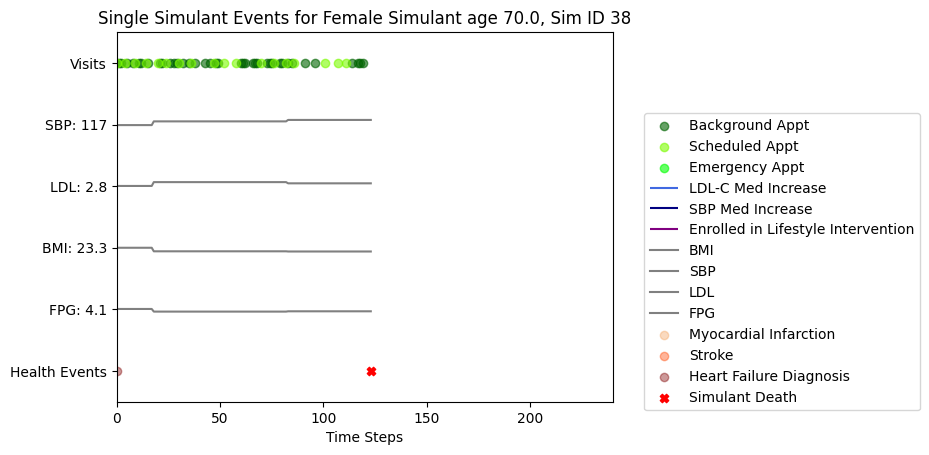

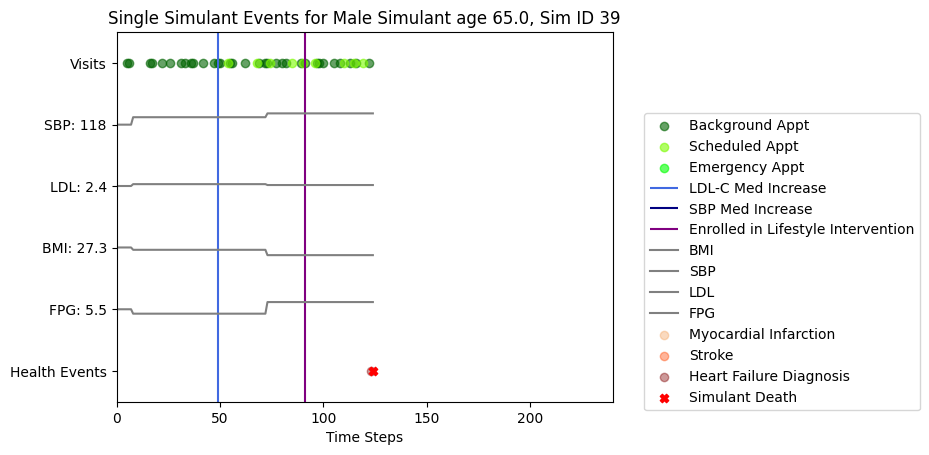

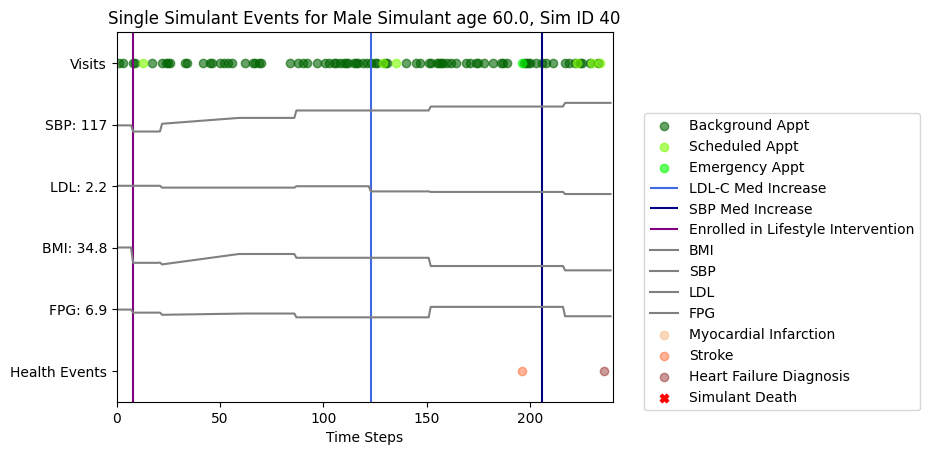

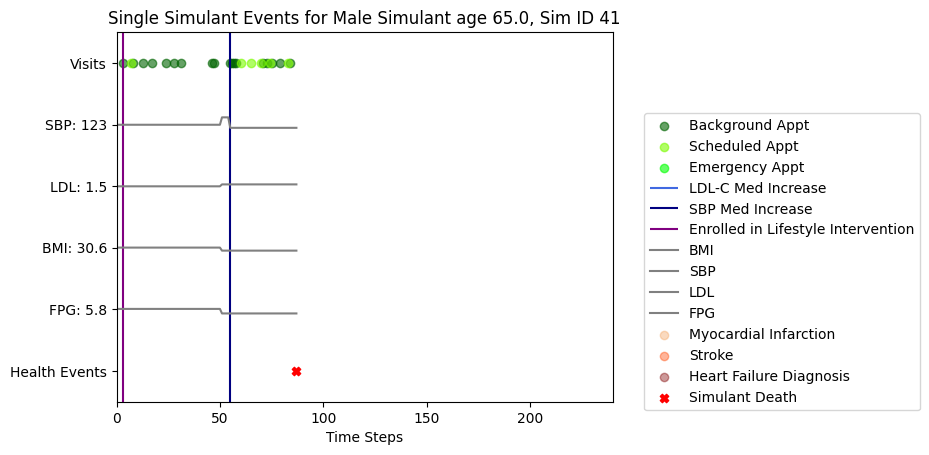

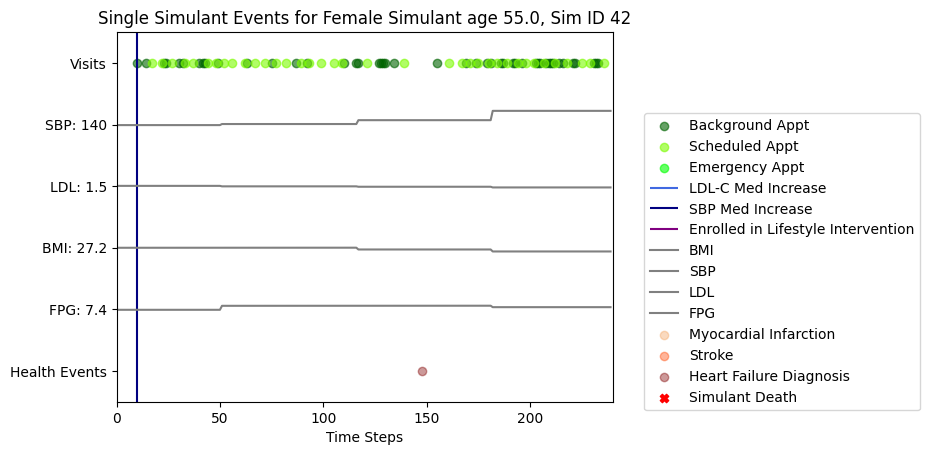

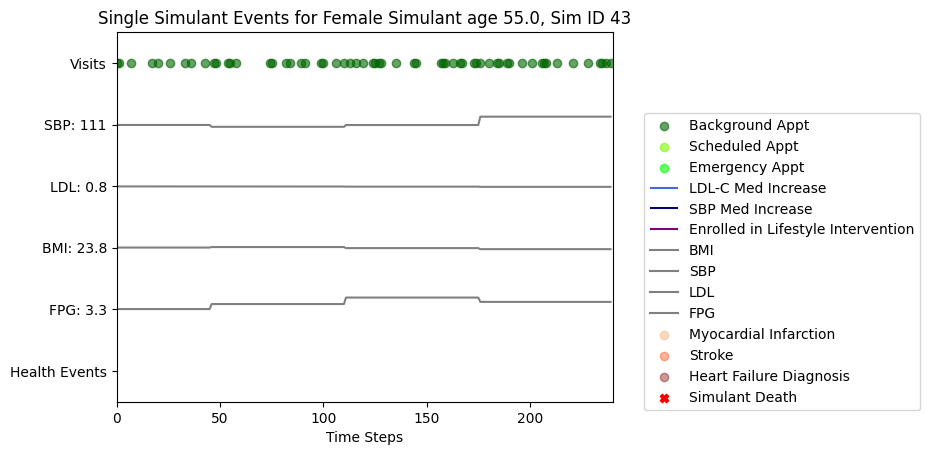

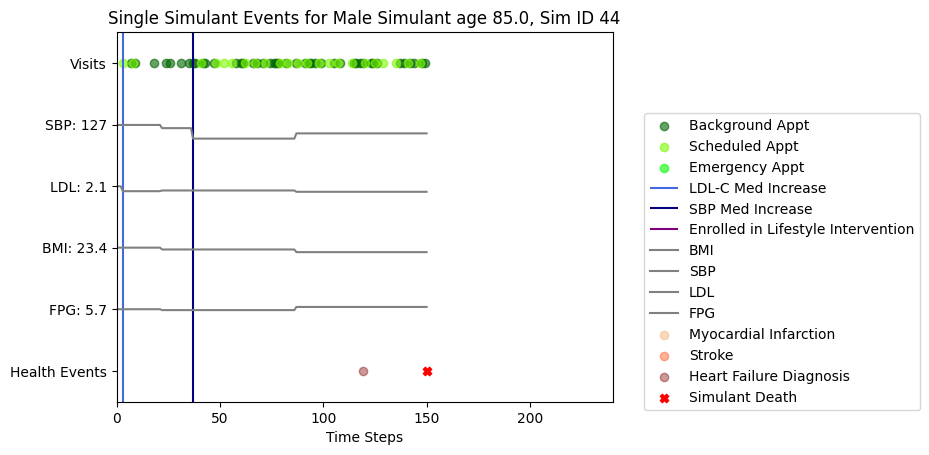

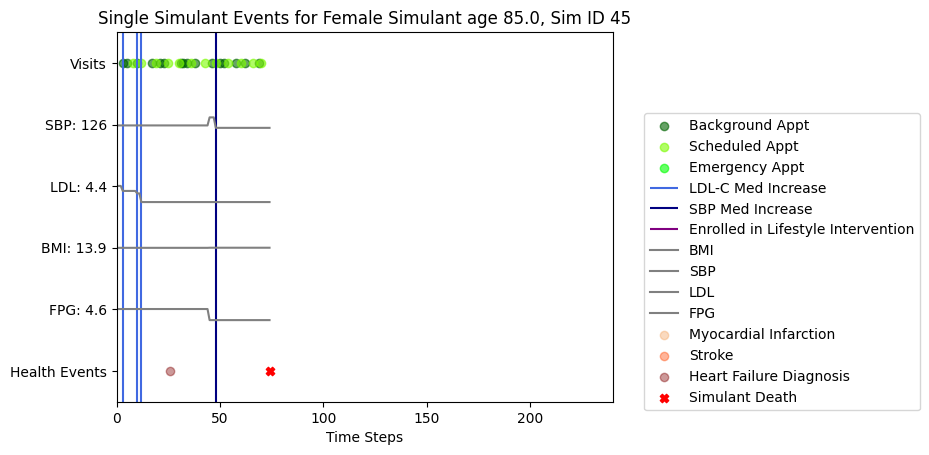

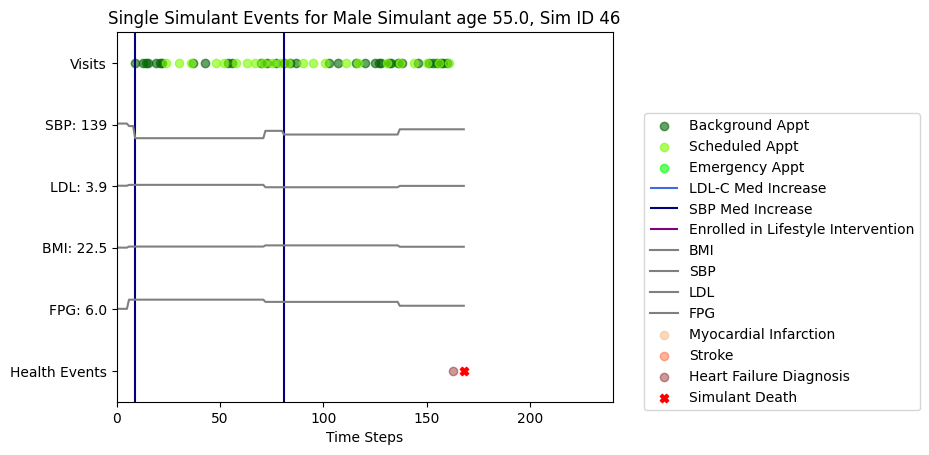

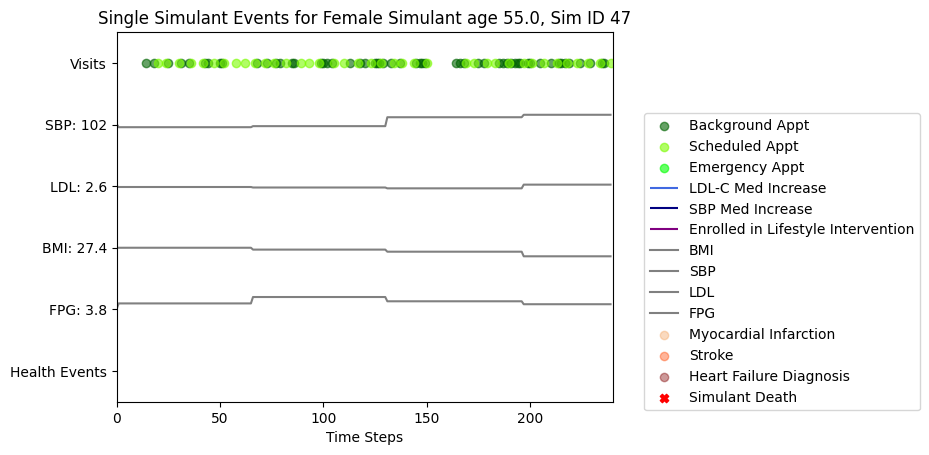

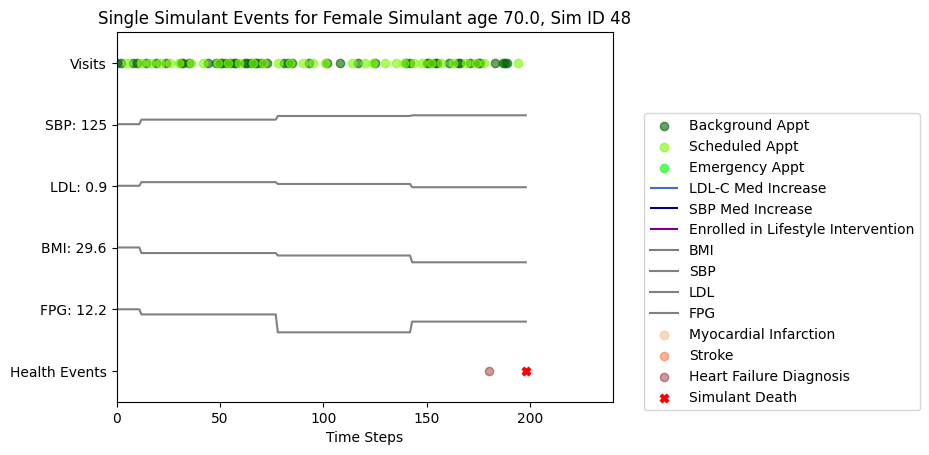

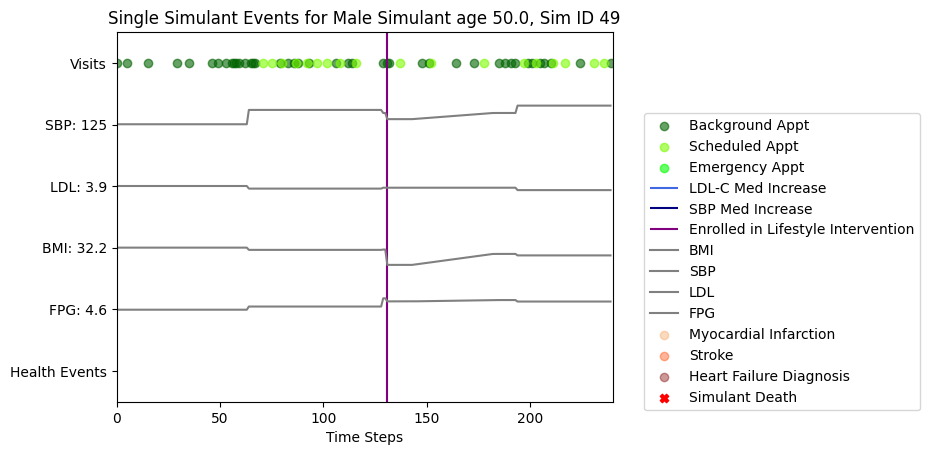

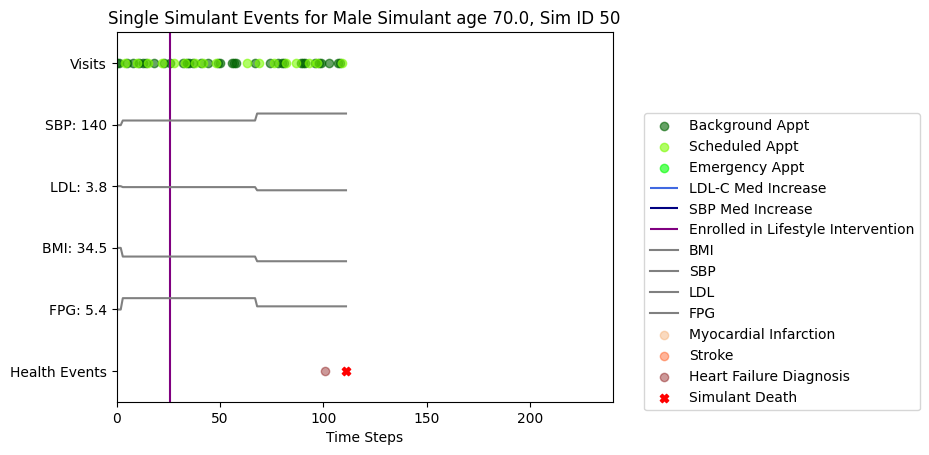

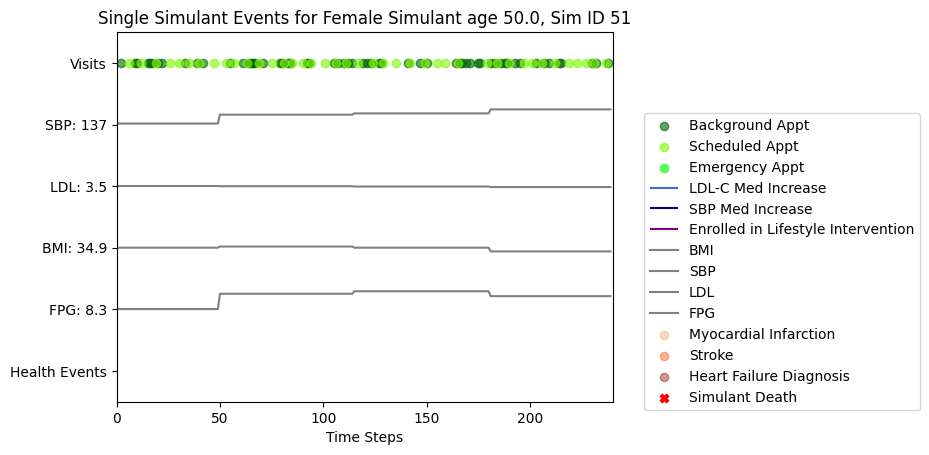

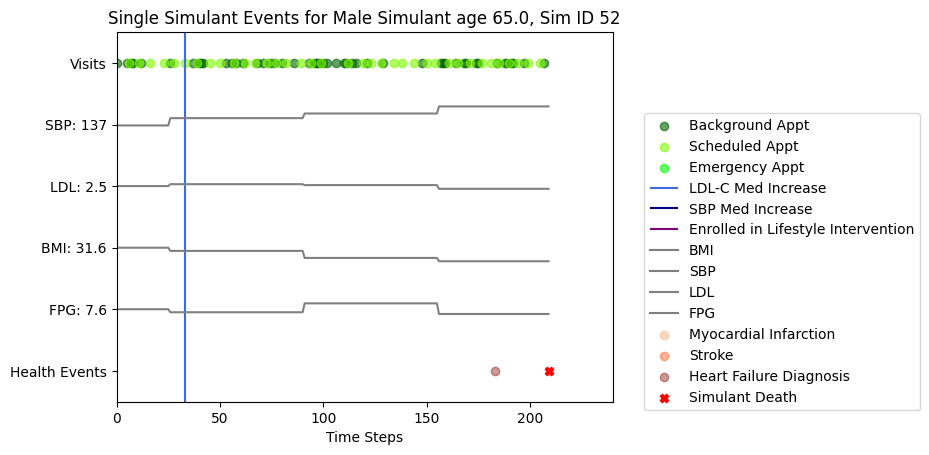

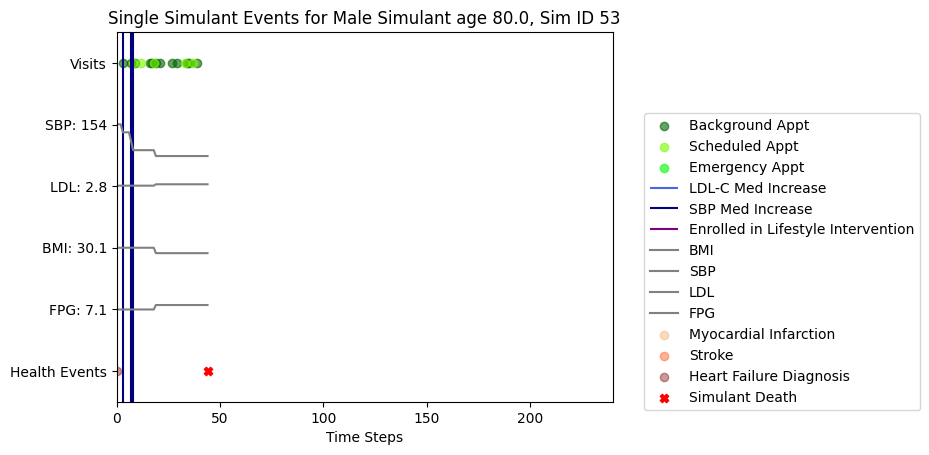

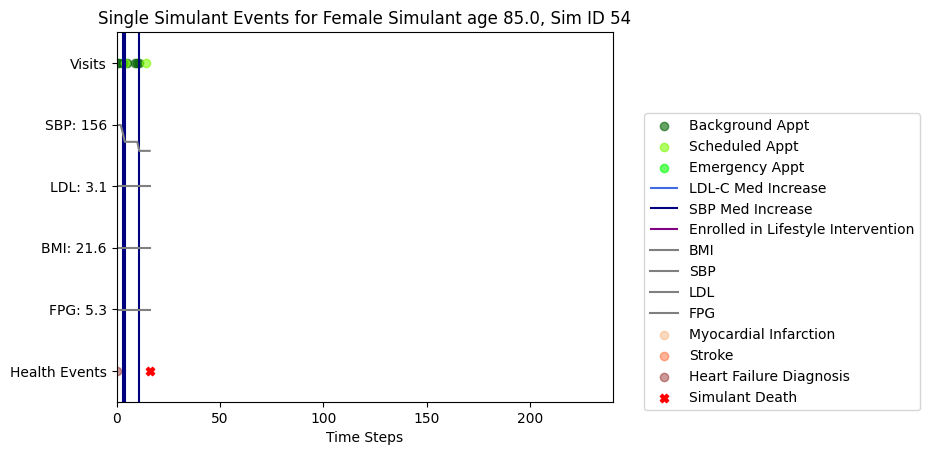

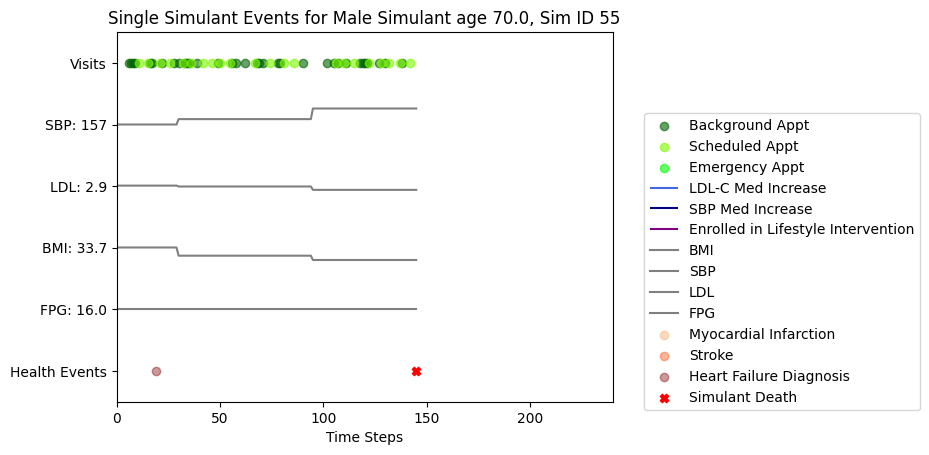

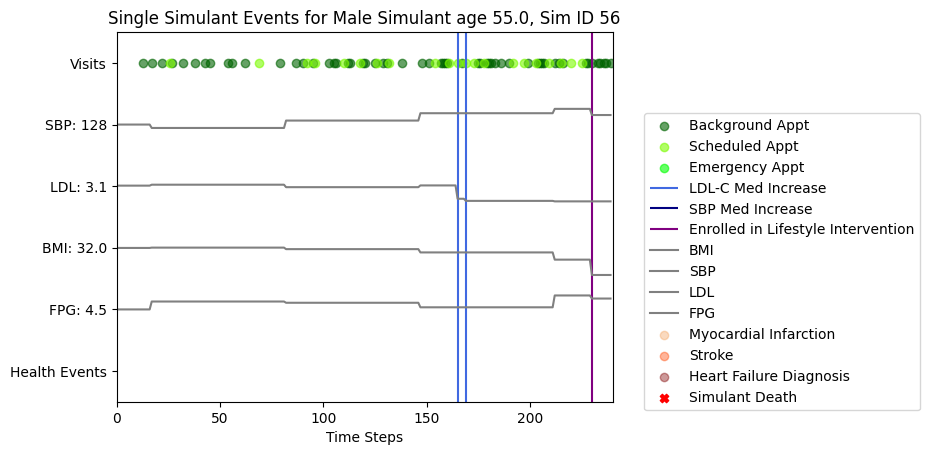

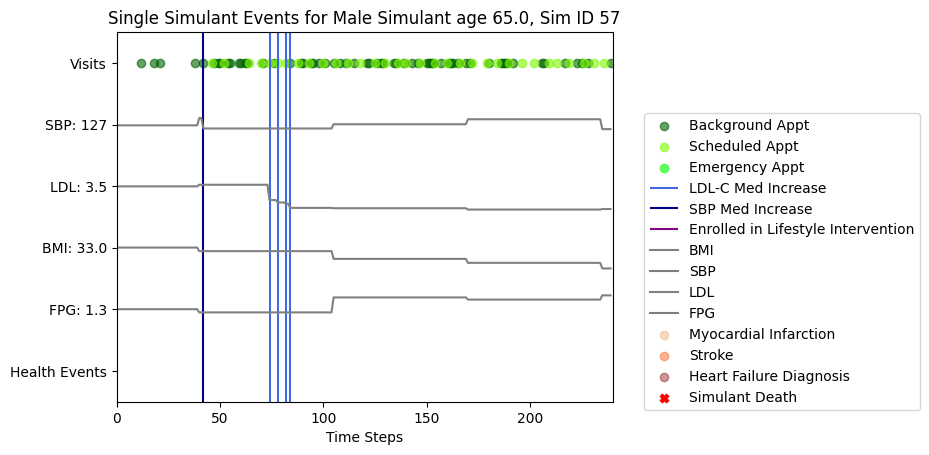

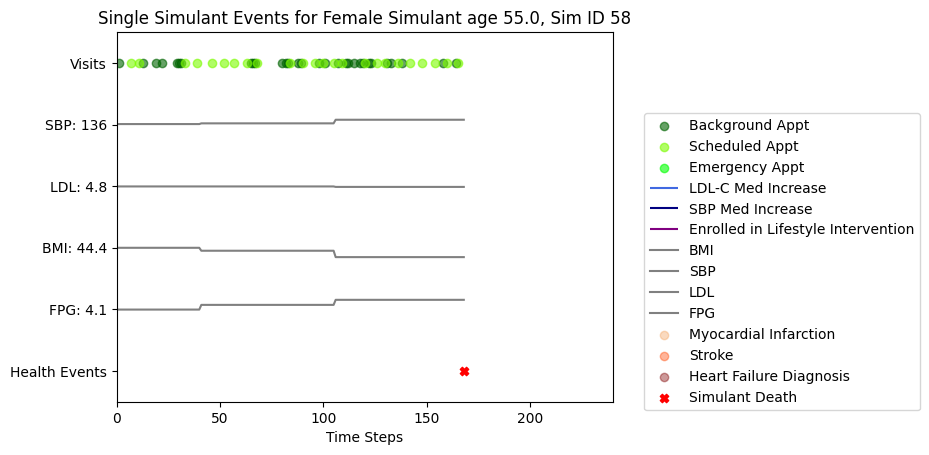

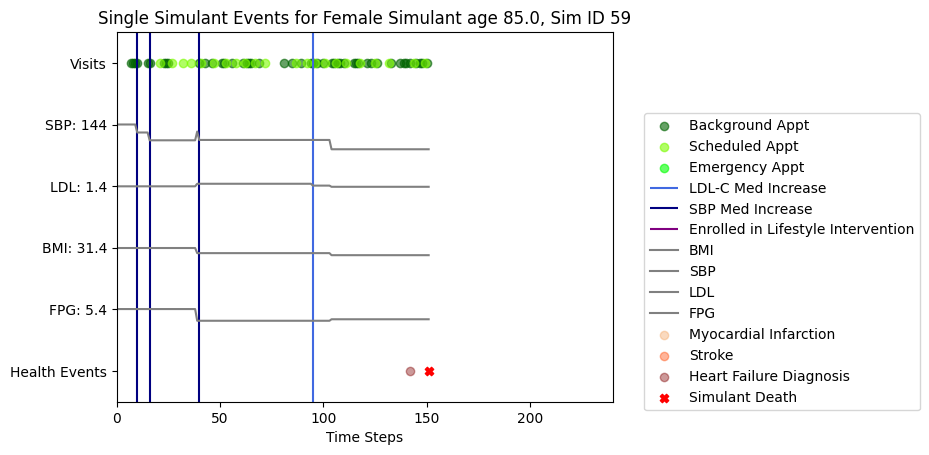

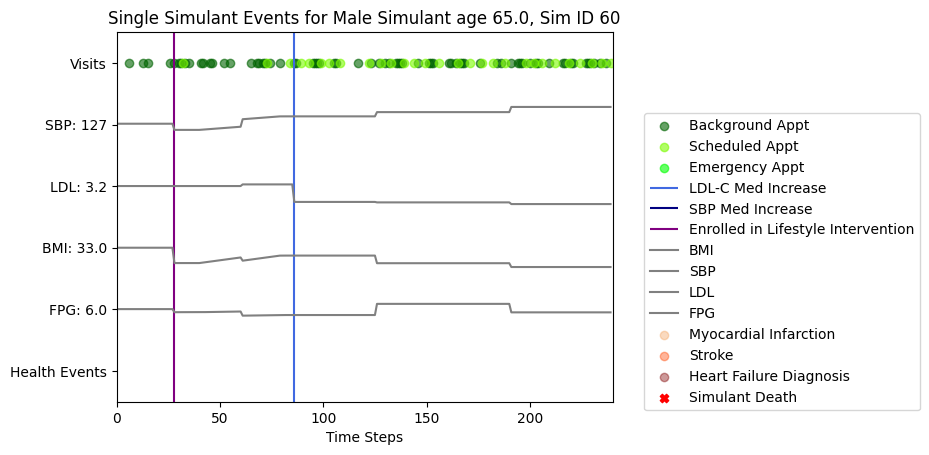

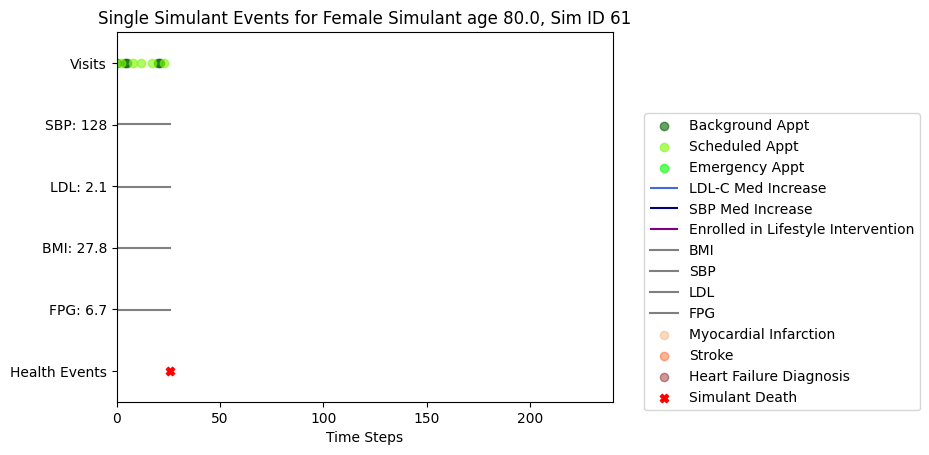

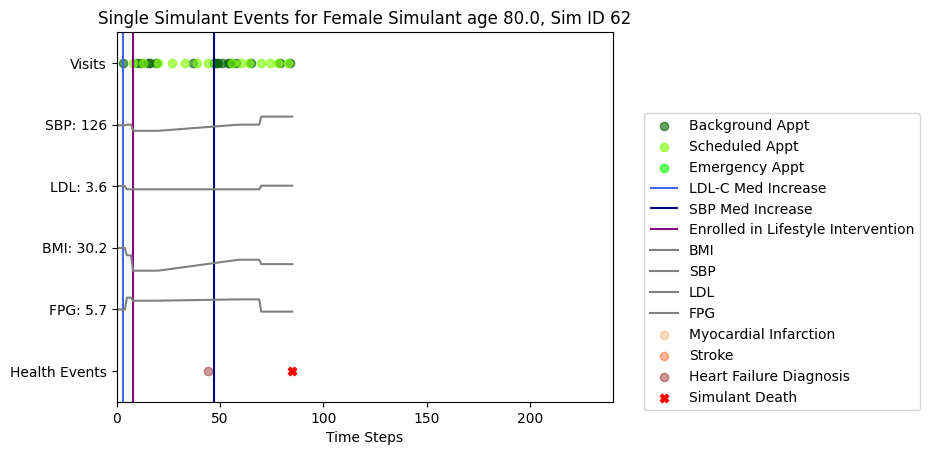

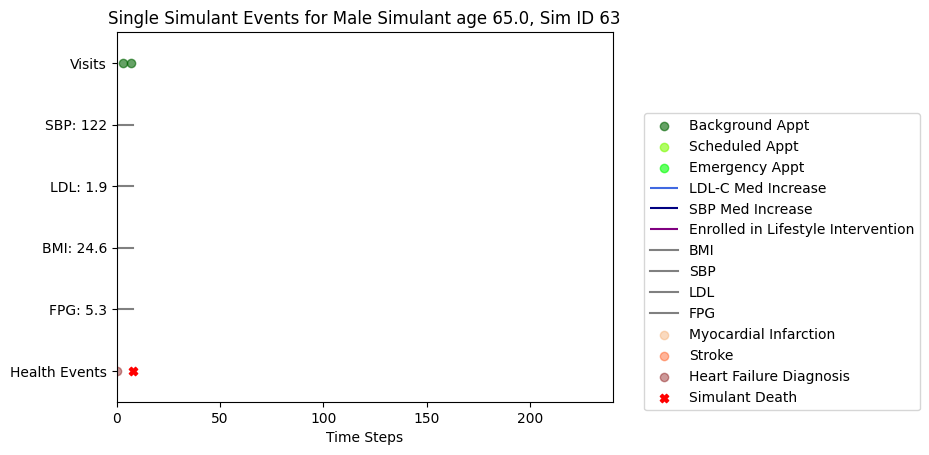

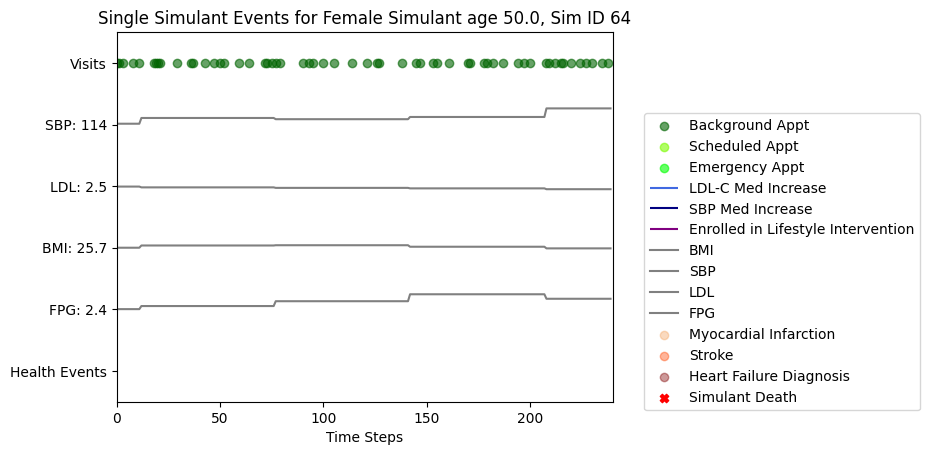

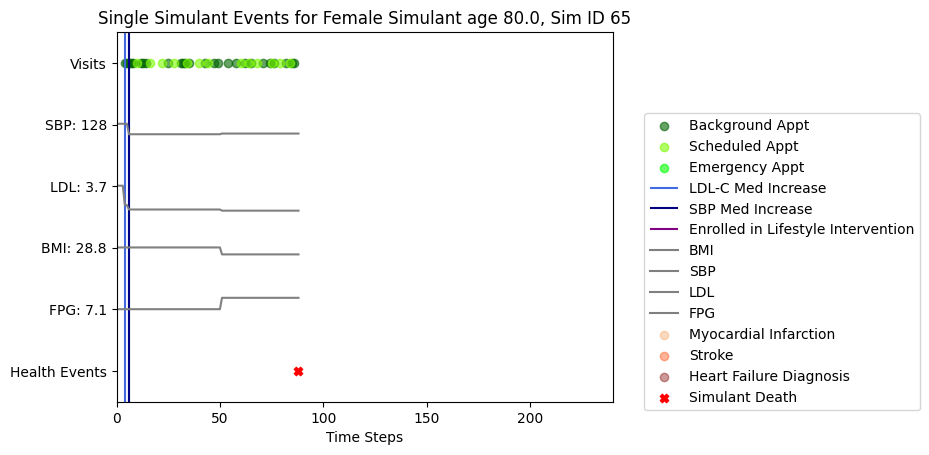

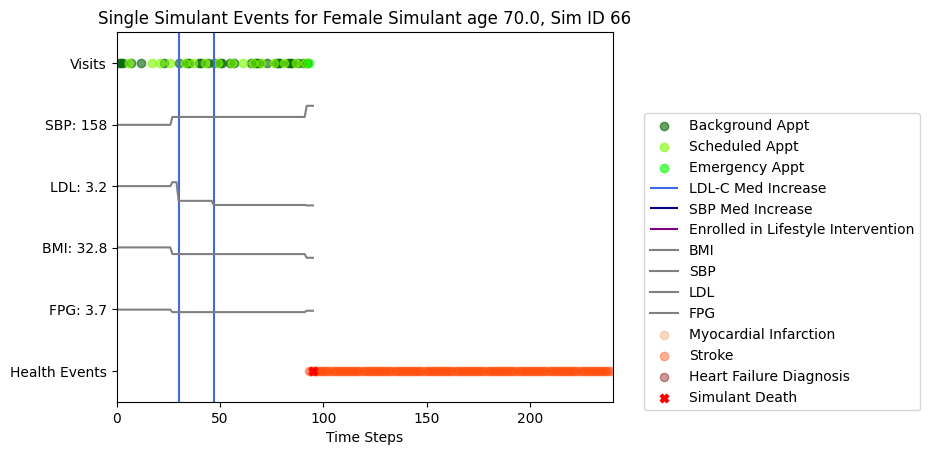

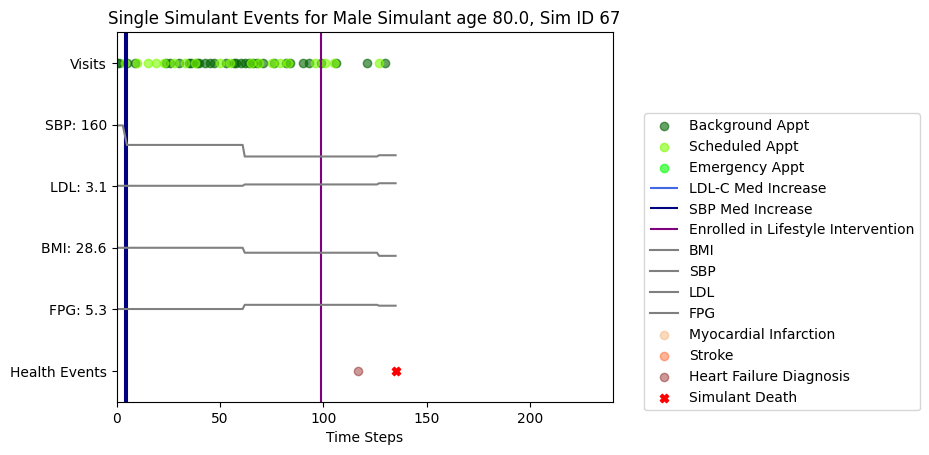

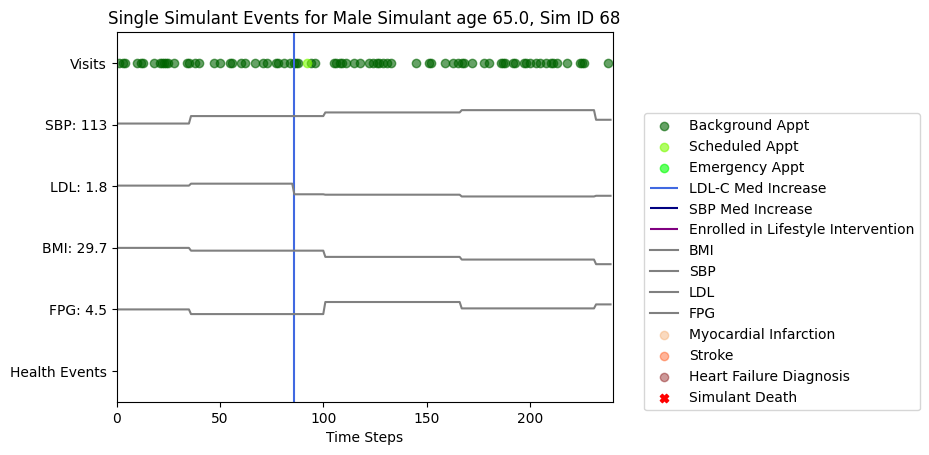

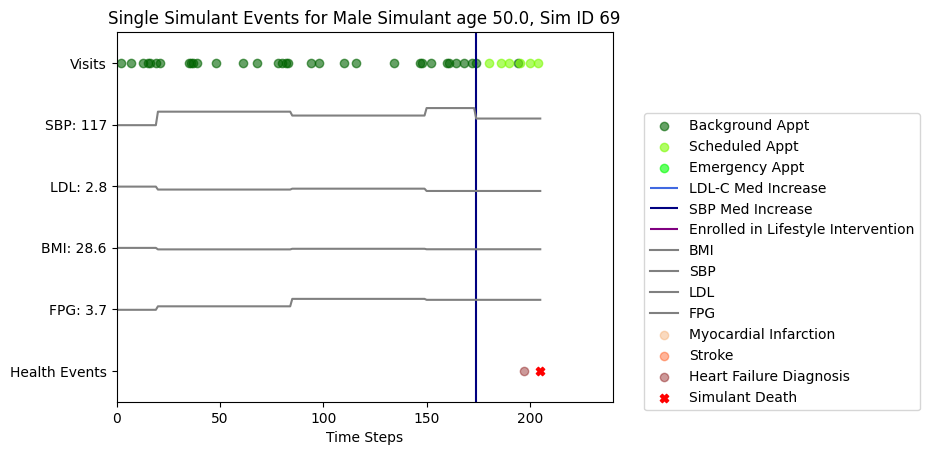

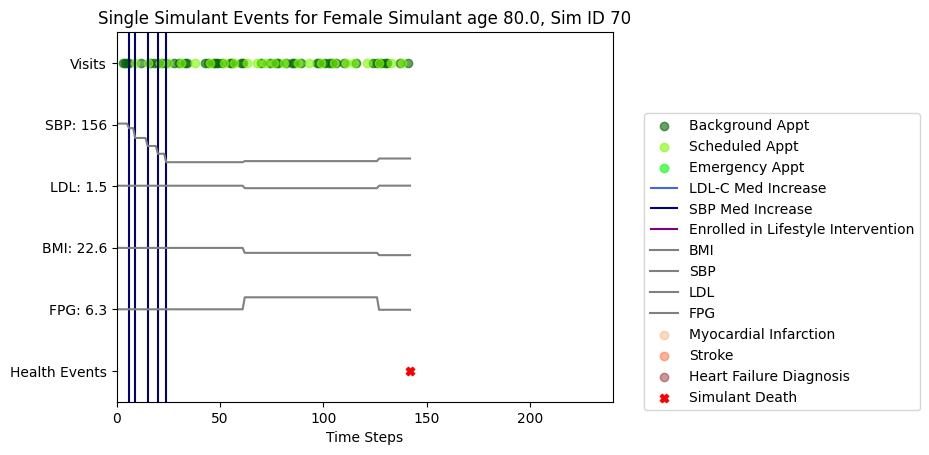

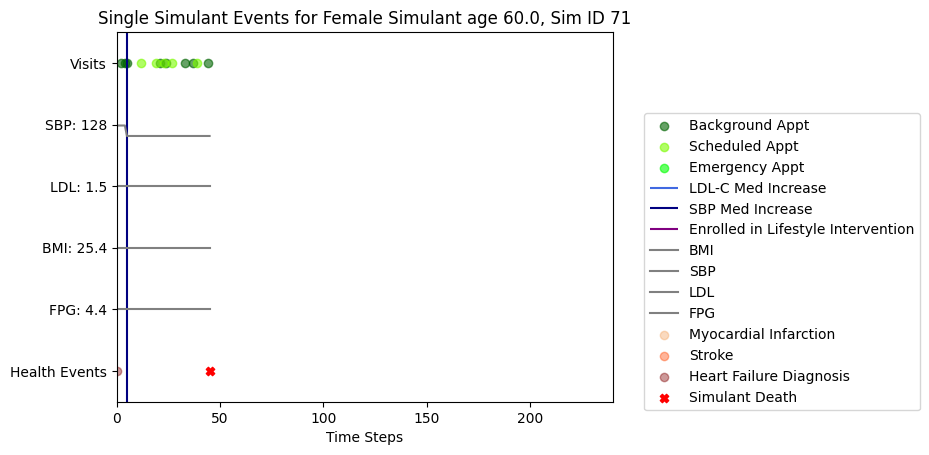

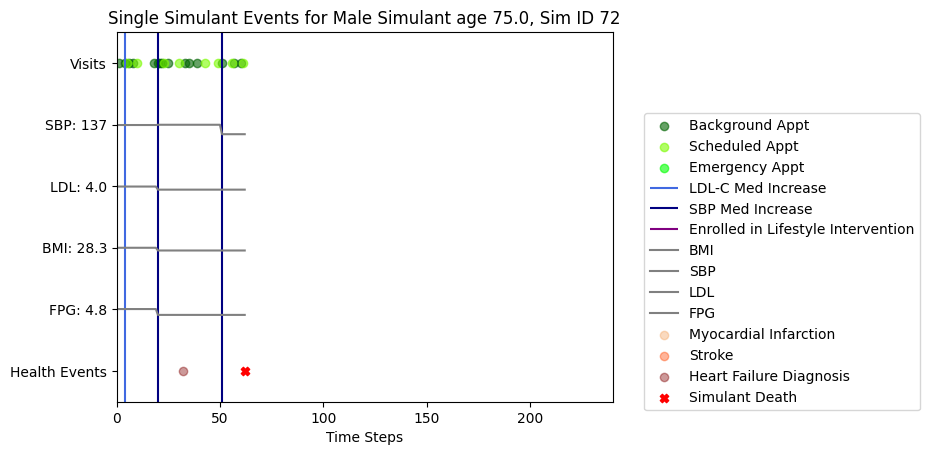

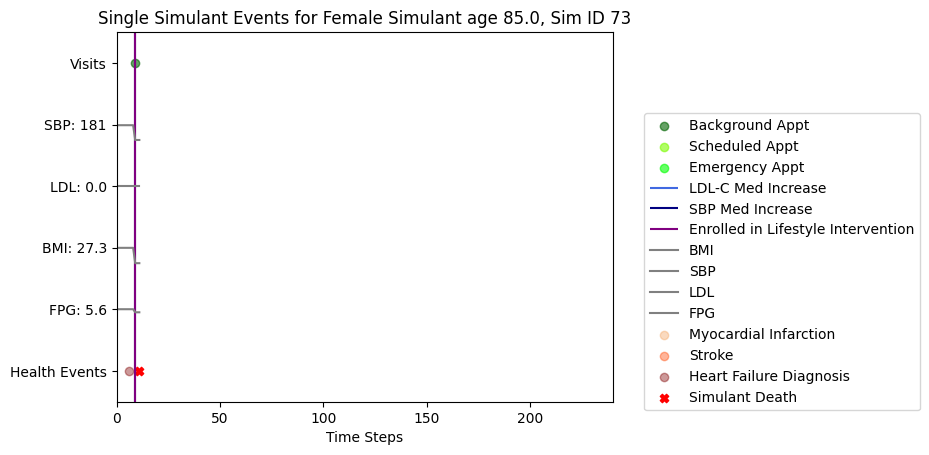

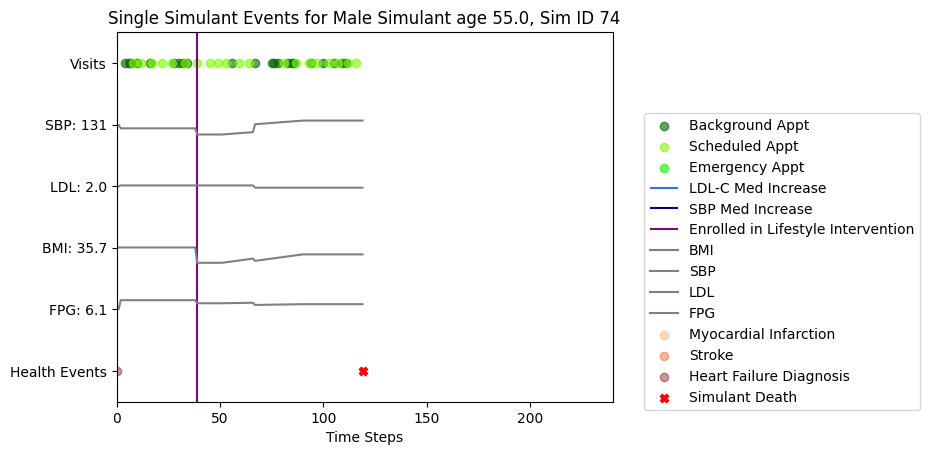

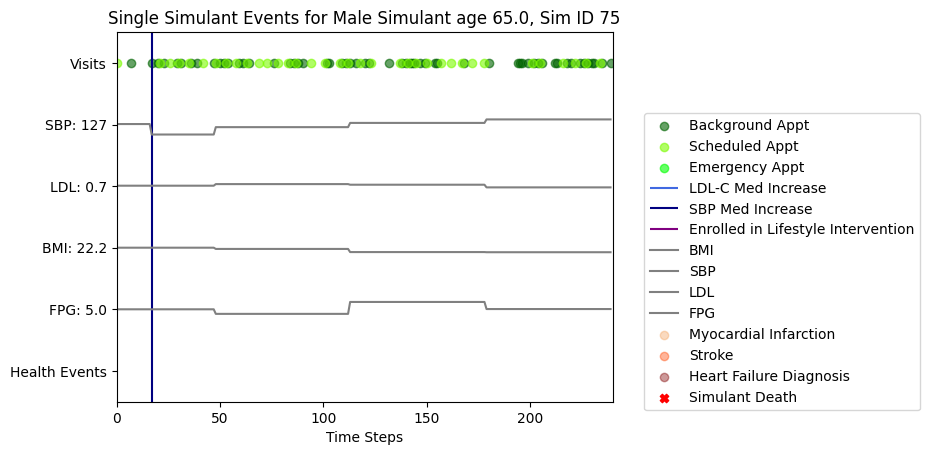

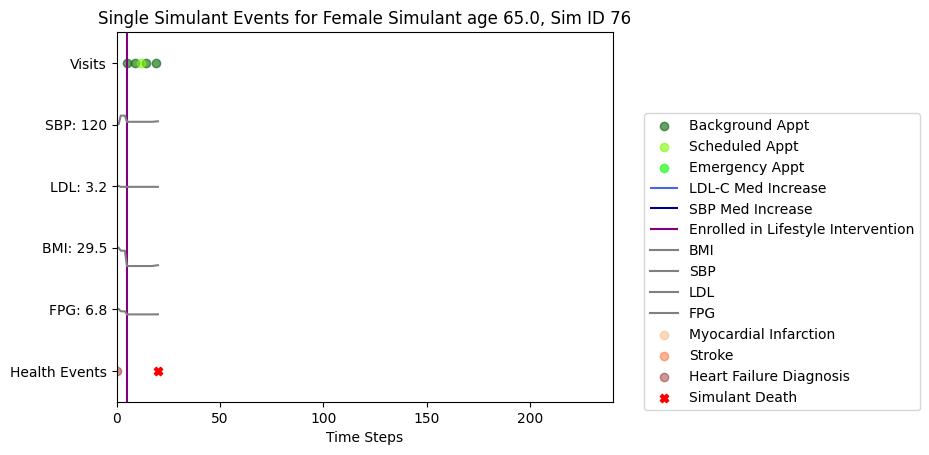

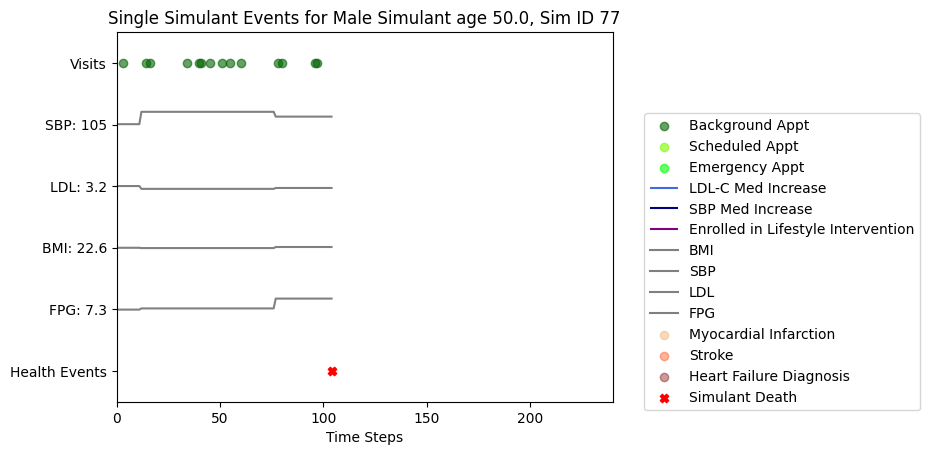

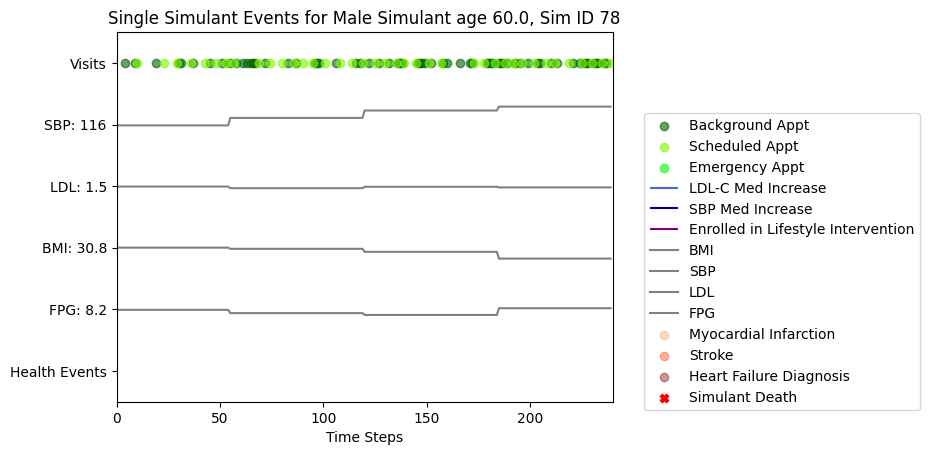

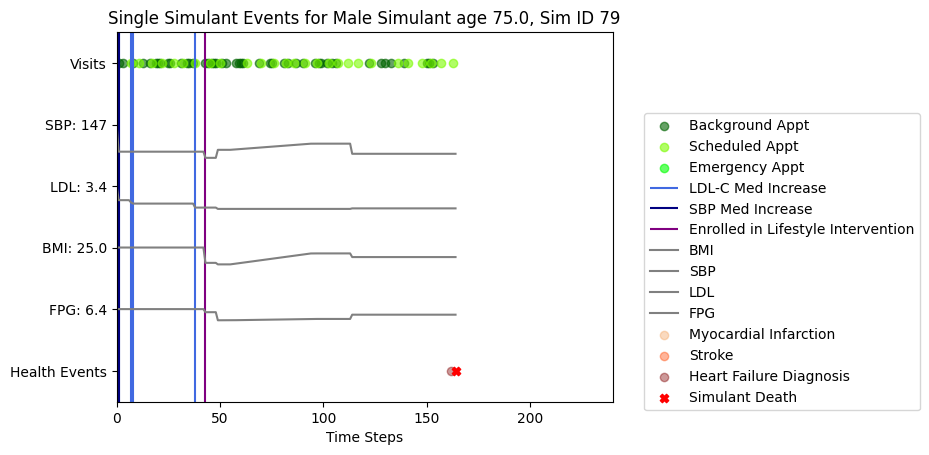

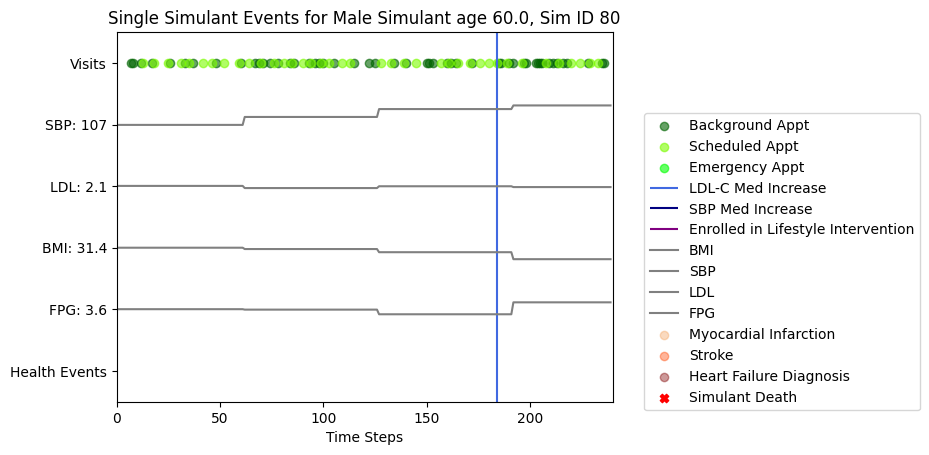

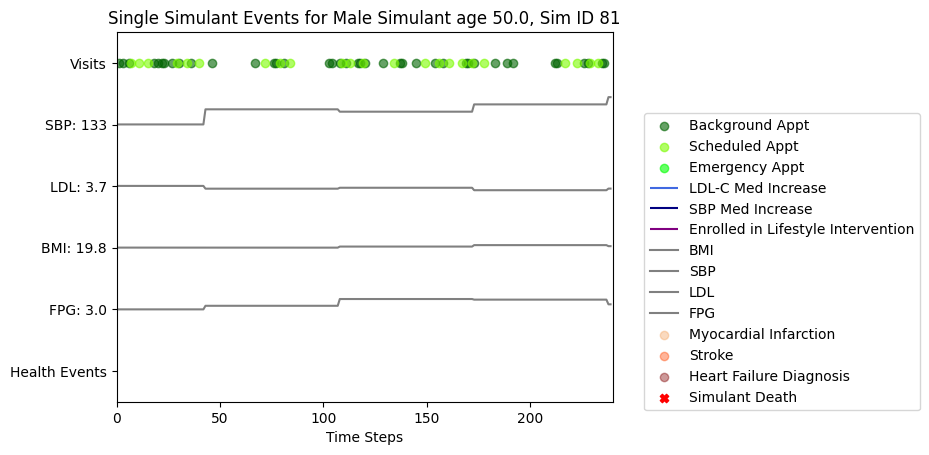

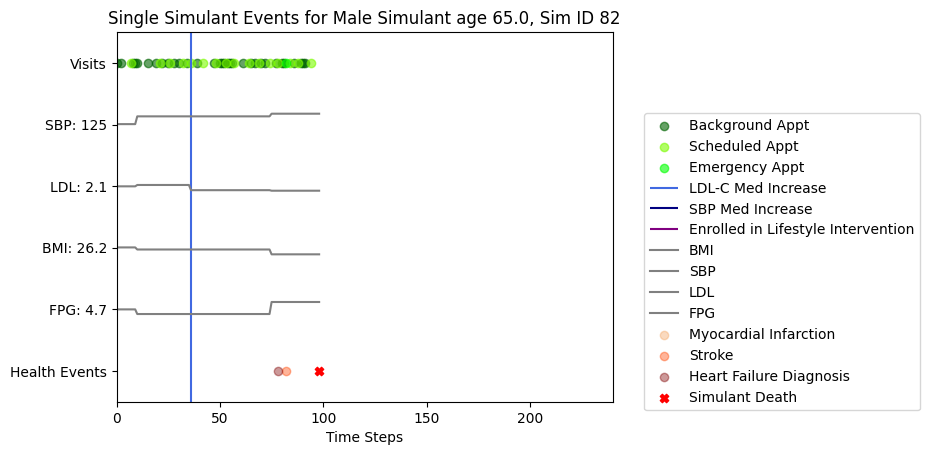

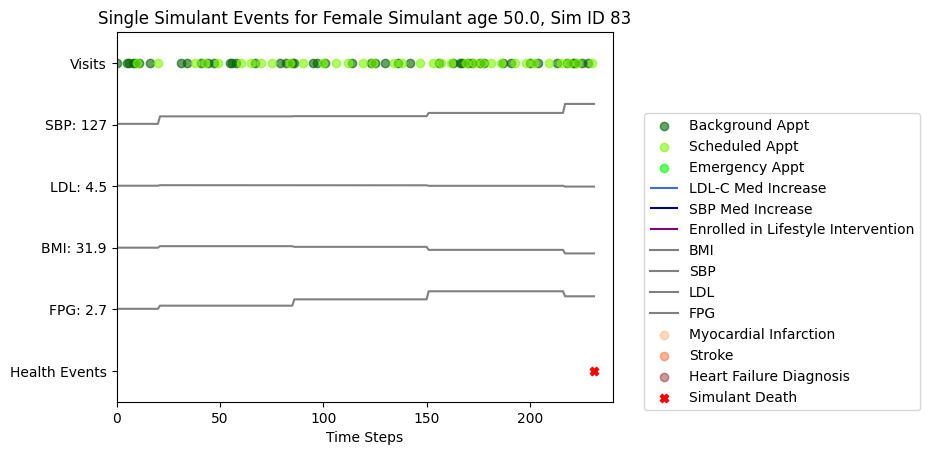

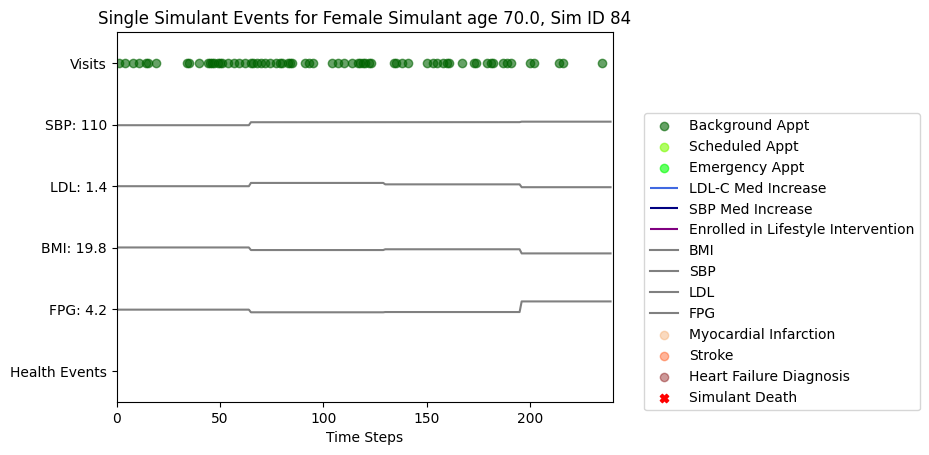

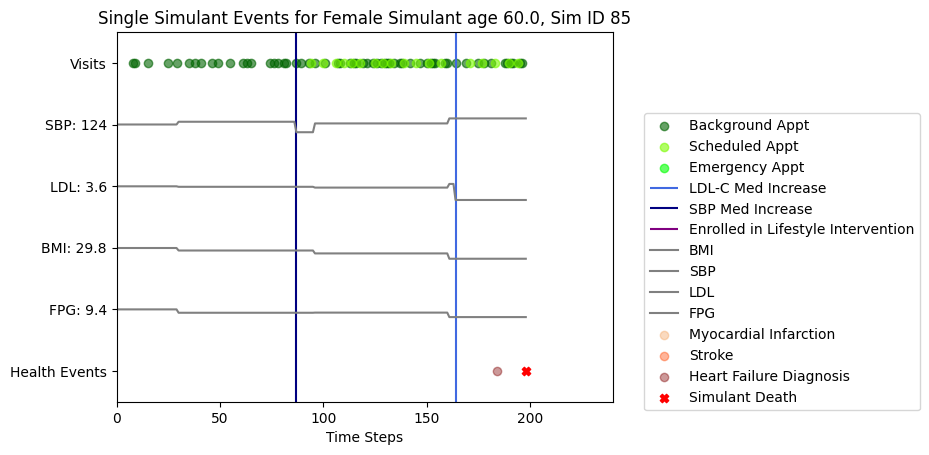

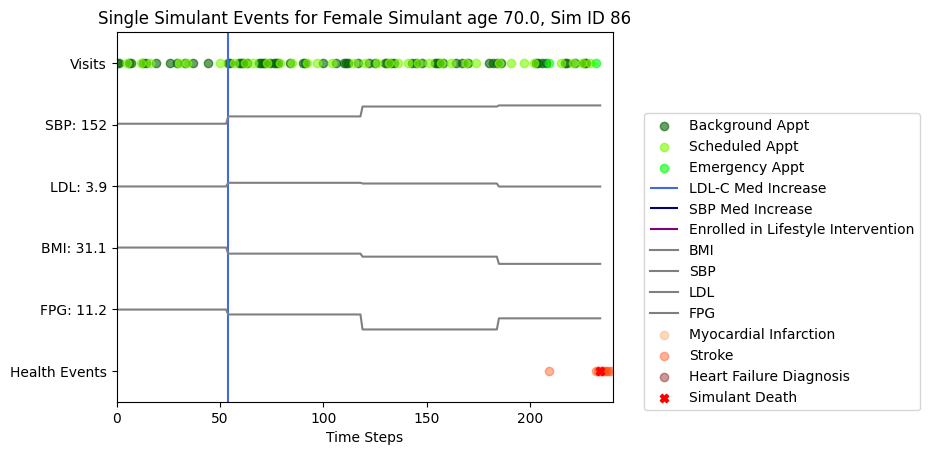

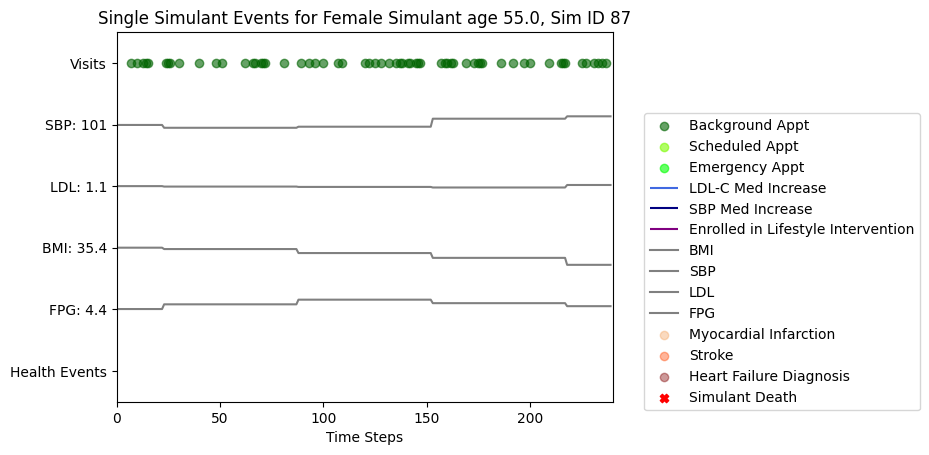

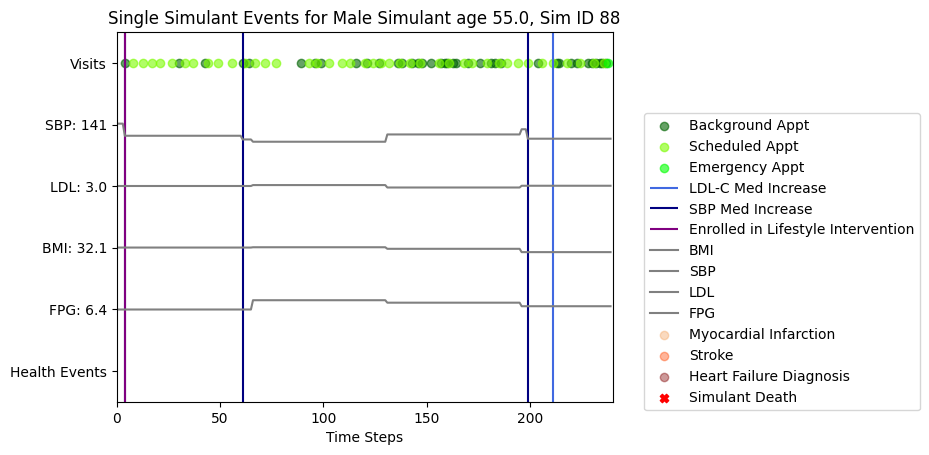

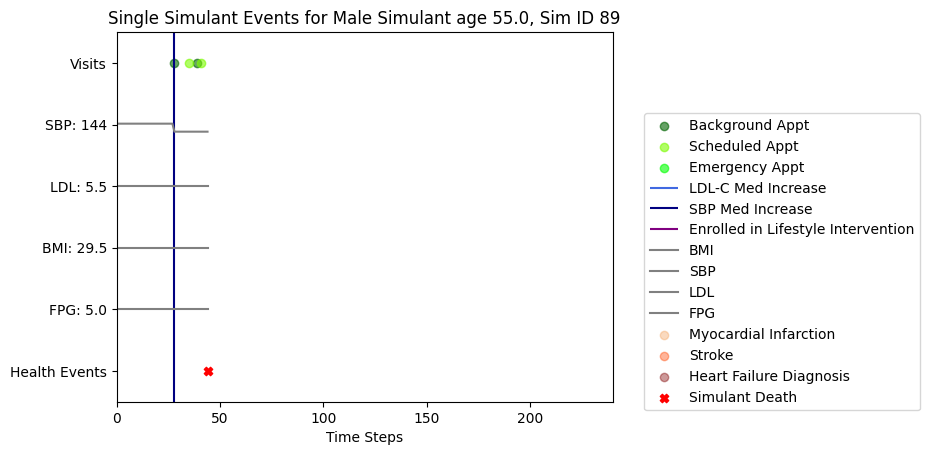

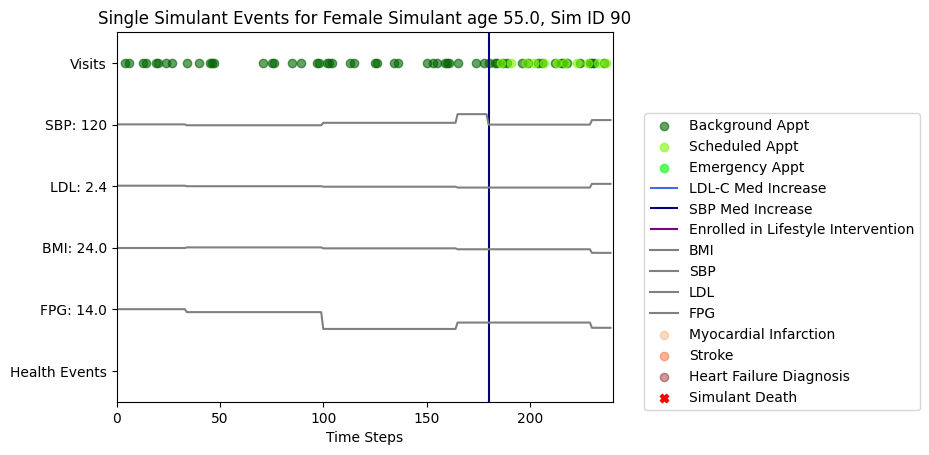

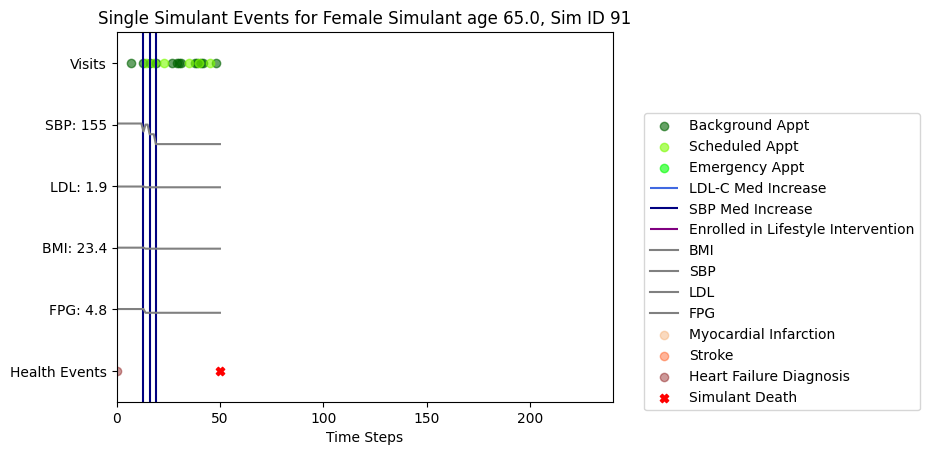

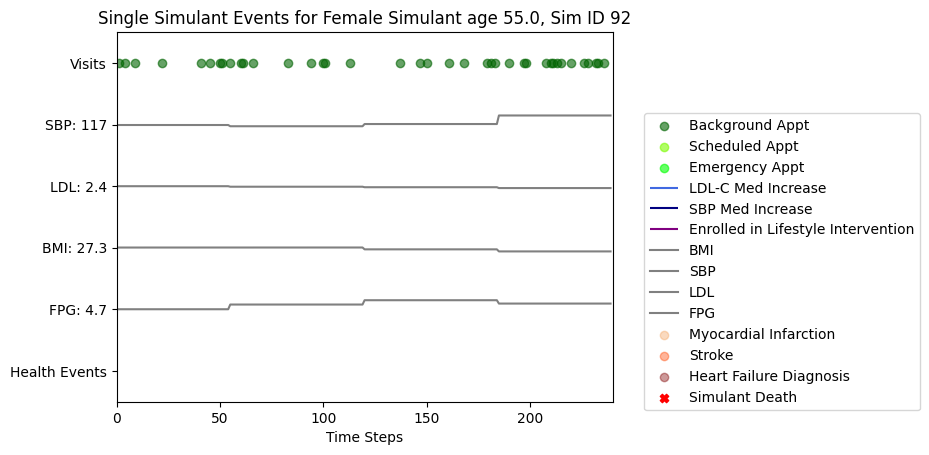

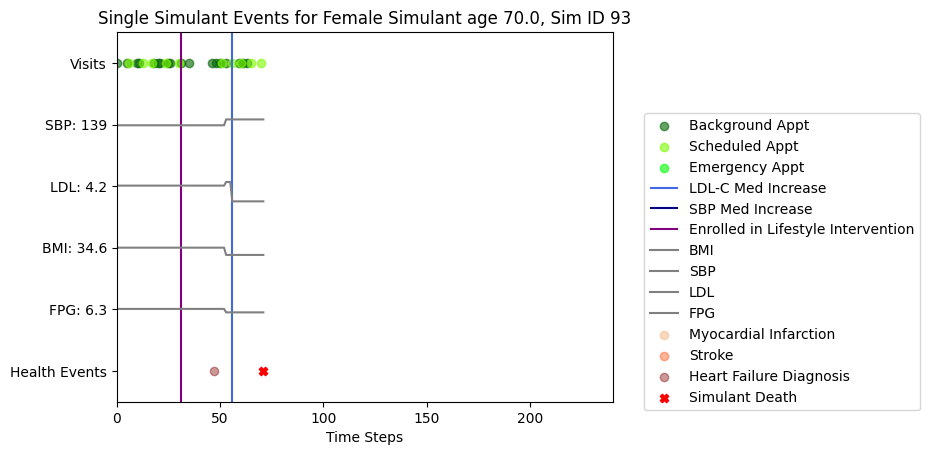

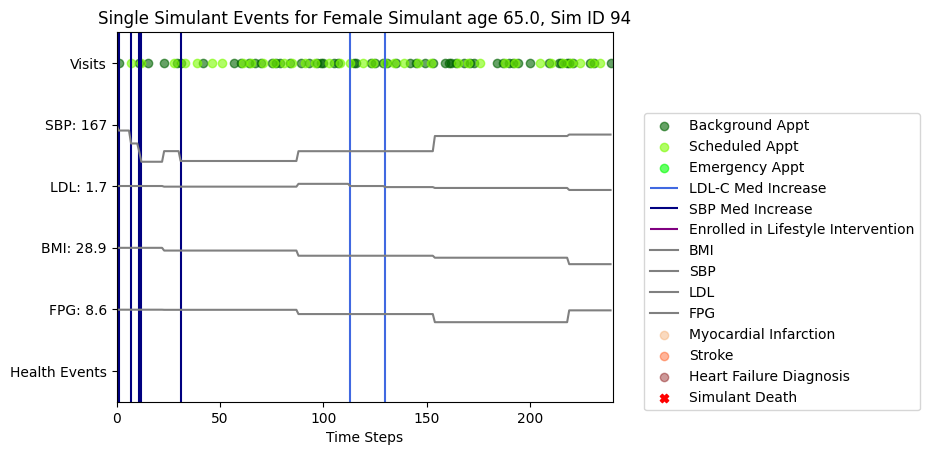

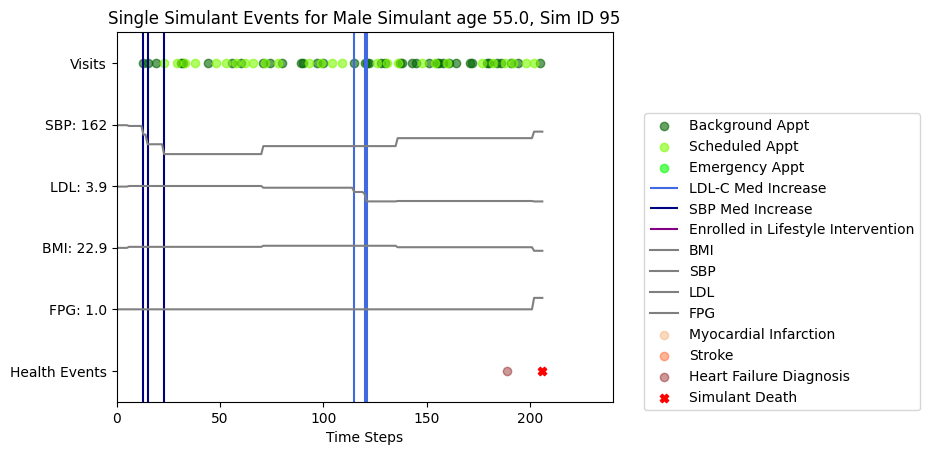

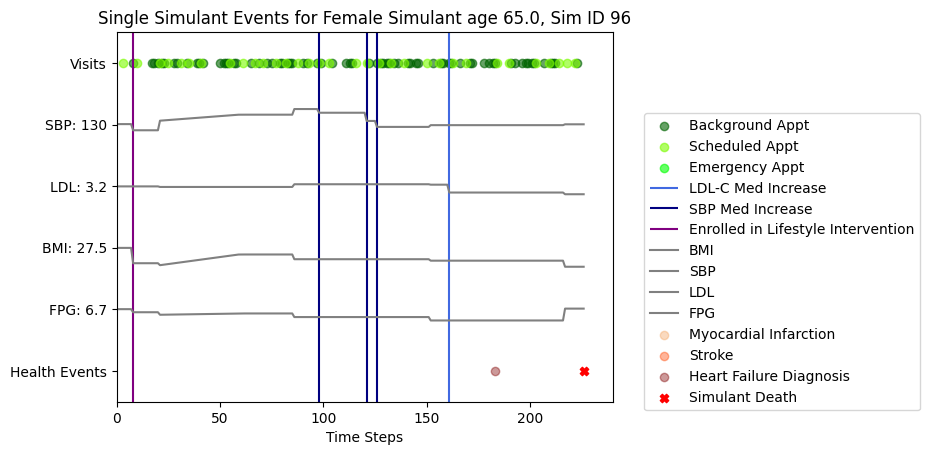

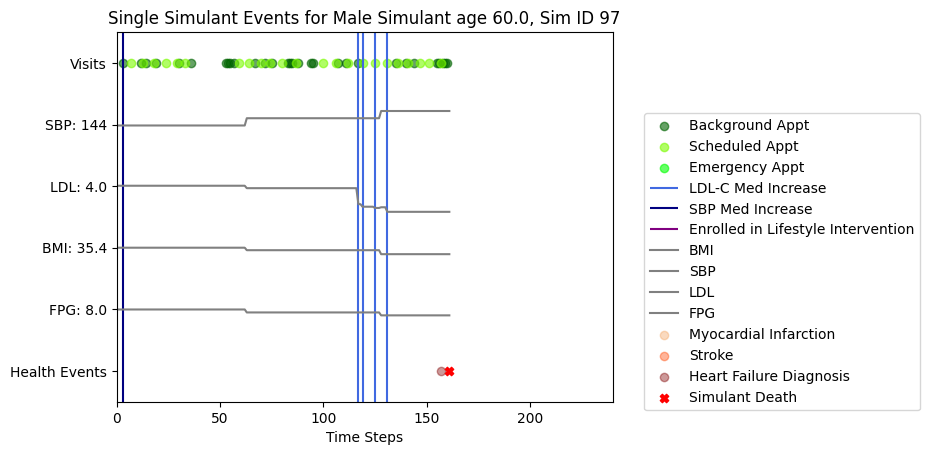

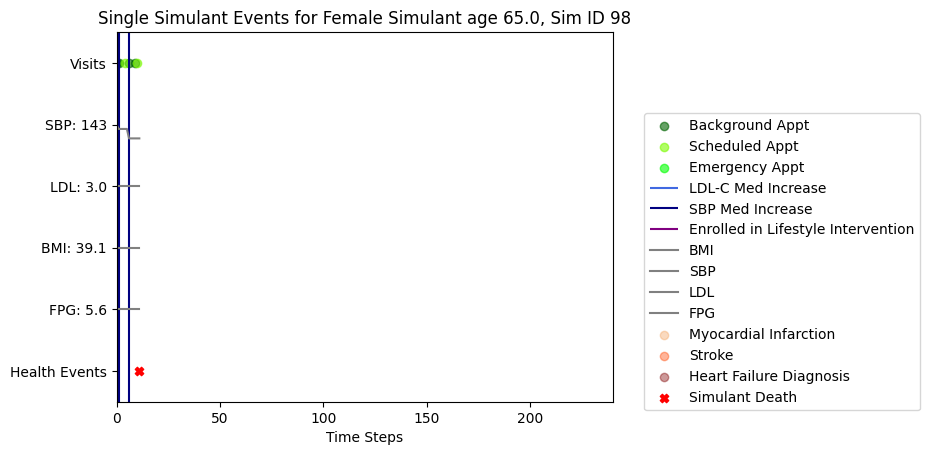

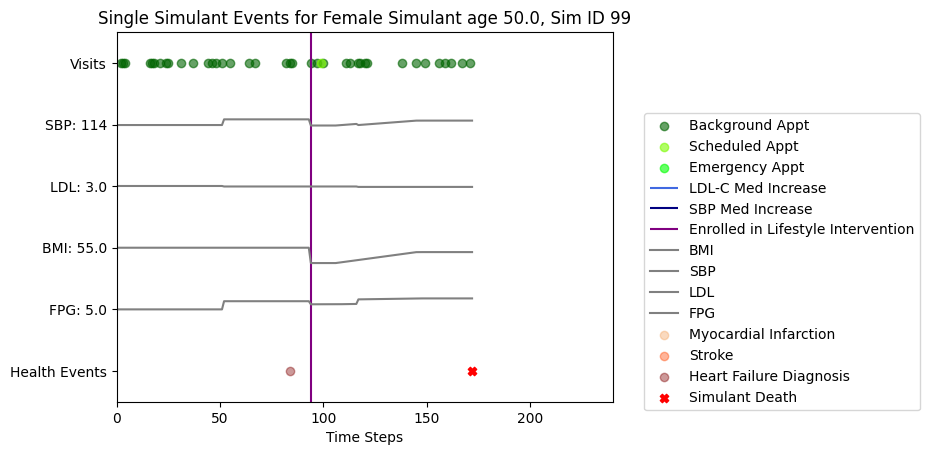

In [25]:
## Baseline graph -  no interventions, all risk factors 

with PdfPages('single_sim_events_100_sims_baseline.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        #plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

In [ ]:
## Lifestyle Graphs - only include BMI and FPG 

with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

In [ ]:
## Polypill Graphs - only include SBP

with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')

In [ ]:
## Outreach Graphs - only include SBP and LDL-C 

with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl_med, ldl_y, sbp_med, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        bmi, bmi_base = bmi_func(single_sim)
        sbp, sbp_base = sbp_func(single_sim)
        ldl, ldl_base = ldl_func(single_sim)
        fpg, fpg_base = fpg_func(single_sim)
        risks_y = single_sim.step.values.tolist()
        if (type(died) == np.int64): 
            risks_y[:] = [x for x in risks_y if x <= died]
            bmi = bmi[:died+1]
            sbp = sbp[:died+1]
            ldl = ldl[:died+1]
            fpg = fpg[:died+1]
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits',f'SBP: {sbp_base}',f'LDL: {ldl_base}',f'BMI: {bmi_base}',f'FPG: {fpg_base}','Health Events']
        y_ticks = [12,10,8,6,4,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.vlines(x = ldl_med, ymin = 1, ymax = 13, colors = 'royalblue', label = 'LDL-C Med Increase')
        plt.vlines(x = sbp_med, ymin = 1, ymax = 13, colors = 'navy', label = 'SBP Med Increase')
        plt.vlines(x = lifestyle, ymin = 1, ymax = 13, colors = 'purple', label = 'Enrolled in Lifestyle Intervention')
        plt.plot(risks_y, bmi, c='gray', label = 'BMI')
        plt.plot(risks_y, sbp, c='gray', label = 'SBP')
        plt.plot(risks_y, ldl, c='gray', label = 'LDL')
        plt.plot(risks_y, fpg, c='gray', label = 'FPG')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,13)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')